# Airbnb in Amsterdam - Data Cleaning & Exploration 

## Introductie

Dit project laat zien hoe nuttige inzichten kunnen worden gehaald uit publieke data. 
De gebruikte data is afkomstig van insideairbnb.com
Bijbehorende blog is te vinden op https://analytics.adapt.nl/?p=3592

### Laden van modules

In [1]:
# Importing the required libraries
from datetime import datetime
from collections import OrderedDict
import time
import re
import string
import pandas as pd 
import numpy as np
import geopandas as gpd
import descartes
from scipy.stats import ttest_ind
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# enable jupyter inline plotting
%matplotlib inline
from IPython.display import SVG
print("Done")

Done


### Laden van nuttige funcites

Met dank aan Laura Lewis (https://towardsdatascience.com/@lvlewis8) voor hergebruik code (op verschillende plaatsen aangepast en/of uitgebreid).

In [2]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=82)
    plt.show()
    
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Mediane prijs ($)')
    ax2.set_xlabel('')
    plt.show()
    
    cat0 = df.loc[df[col] == 0.0].price
    cat1 = df.loc[df[col] == 1.0].price
    tstatistic, pvalue = ttest_ind(cat0, cat1)
    print('P-value is %6.2e' % pvalue)
    
    
    cat0_median =(df.loc[df[col] == 0.0].price.median())
    cat1_median = (df.loc[df[col] == 1.0].price.median())
    cat0_count =(df.loc[df[col] == 0.0].price.count())
    cat1_count =(df.loc[df[col] == 1.0].price.count())
    print("There are " + str(cat0_count) + " without " + str(col) + ", with a median price of " + str(cat0_median))
    print("There are " + str(cat1_count) + " with "  + str(col) + ", with a median price of " + str(cat1_median))

    if pvalue < (0.05/106):
        print("Effect is significant!")
    
    df.groupby(col).price
    return pvalue

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    

# Laden van data

We beginnen met het laden van de data. De data beschikbaar via InsideAirbnb update automatisch. Voor reproduceerbaarheid heb ik een specifieke _freeze_ van de data geupload naar een eigen server.

In [3]:
# load data
raw_df = pd.read_csv("https://klaasjan.eu/files/airbnb/listings_detailed.csv.gz", low_memory=False)
print(f"The dataset contains {len(raw_df)} Airbnb listings")

# Set pandas max columns to number of columns in data
pd.set_option('display.max_columns', len(raw_df.columns)) 
pd.set_option('display.max_rows', 110) 
raw_df.head()

The dataset contains 20025 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20191207212953,2019-12-08,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Indische Buurt,Oostelijk Havengebied - Indische Buurt,NaN,Amsterdam,North Holland,NaN,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.36575,4.94142,f,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",NaN,$59.00,NaN,"$1,500.00",$200.00,$60.00,1,$20.00,3,15,3,3,1125,1125,3.0,1125.0,2 months ago,t,0,0,0,0,2019-12-08,277,29,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.13
1,20168,https://www.airbnb.com/rooms/20168,20191207212953,2019-12-08,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,For those who like all facets of city life. In...,17th century Dutch townhouse in the heart of t...,none,Located just in between famous central canals....,Check-in time from 2pm till 10pm (But it doesn...,No need to use any transport! All is within a ...,NaN,"No curfew, free entrance 27/7 with your own ke...",This studio/room takes entire floor and has it...,NaN,NaN,https://a0.muscache.com/im/pictures/69979664/3...,NaN,59484,https://www.airbnb.com/users/show/59484,Alexander,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",Secondary phone nr. + (Phone number hidden by ...,within an hour,100%,NaN,f,https://a0.mu

## Data cleaning

### Verwijderen overbodige kolommen

Verwijder kolommen die geen informatie toevoegen (bijvoorbeeld de URL), of hetzelfde is voor elke accommodatie (zoals land of stand). 

In [4]:
# Drop columns that are unnecessary or with too many missing values
print(f"The dataset contains {len(raw_df)} Airbnb listings")
#cols_to_drop = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'calculated_host_listings_count','latitude','longitude','host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','host_response_time','host_response_rate','host_acceptance_rate','neighbourhood_group_cleansed','square_feet','license','weekly_price',]
#raw_df.drop(cols_to_drop, axis=1, inplace = True)
cols_to_drop = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','street','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url', 'host_name','calculated_host_listings_count','host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','host_acceptance_rate','neighbourhood_group_cleansed','square_feet','license','weekly_price','monthly_price','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','jurisdiction_names','maximum_nights_avg_ntm','calendar_updated','neighbourhood','city','state','zipcode','market','smart_location','country_code','country','number_of_reviews_ltm','reviews_per_month','has_availability','availability_30','availability_60','availability_90','host_has_profile_pic','require_guest_profile_picture','has_availability','is_business_travel_ready','require_guest_phone_verification','requires_license','is_location_exact']
cols_to_drop
df = raw_df.drop(cols_to_drop, axis=1)
print(f"The dataset contains {len(df)} Airbnb listings")
df.isna().sum()
df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace = True)
print(raw_df.isna().sum())

The dataset contains 20025 Airbnb listings
The dataset contains 20025 Airbnb listings
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               34
summary                                           635
space                                            5371
description                                       242
experiences_offered                                 0
neighborhood_overview                            6384
notes                                           11636
transit                                          6103
access                                           8691
interaction                                      7931
house_rules                                      7810
thumbnail_url                                   20025
medium_url                                      20

###  Ontbrekende waardes (missing data)

Sommige waarden zijn onbekend. Zo is bijvoorbeeld niet van elke listing het aantal bedden bekend, of hoelang een host al op Airbnb geregistreerd staat. Sommige data is essentieel, wat betekent dat we die listing niet mee kunnen nemenen in analyses. In andere gevallen kunnen we de op een andere manier omgaan met de missende waarde, door deze bijvoorbeeld te vervangen door de mediana vaarde van de kolom, of door een specifieke waarde. Het ontbreken van schoonmaakkosten kunnen we opvatten als geen schoonmaakkosten, dus dit kan op nul worden gezet. We zullen dit per waarde moeten bepalen.

In [5]:
df.isna().sum()

host_since                                       158
host_response_time                              9349
host_response_rate                              9349
host_is_superhost                                158
host_listings_count                              158
host_total_listings_count                        158
host_identity_verified                           158
neighbourhood                                      0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                          6
bedrooms                                          13
beds                                              31
bed_type                                           0
amenities                                          0
price                                         

### Overige data-cleaningstappen

In [6]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Convert prices from string to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
print(f"The dataset contains {len(df)} Airbnb listings")

The dataset contains 20025 Airbnb listings


### Eerste exploratie data

Te zien dat de meeste listings review scores van 9 of 10 krijgen. Het aantal bathrooms is meestal 1, maar er zijn ook waardes van 1.4 mogelijk. Er zijn enkele heel grote accomodaties waar veel mensen terecht kunnen (meer dan 10). Een minderheid is superhost. De prijs ligt tussen de 50 en 200 voor verreweg de meeste accomodaties, maar er zijn enkele uitschieters naar een paar duizend per nacht.

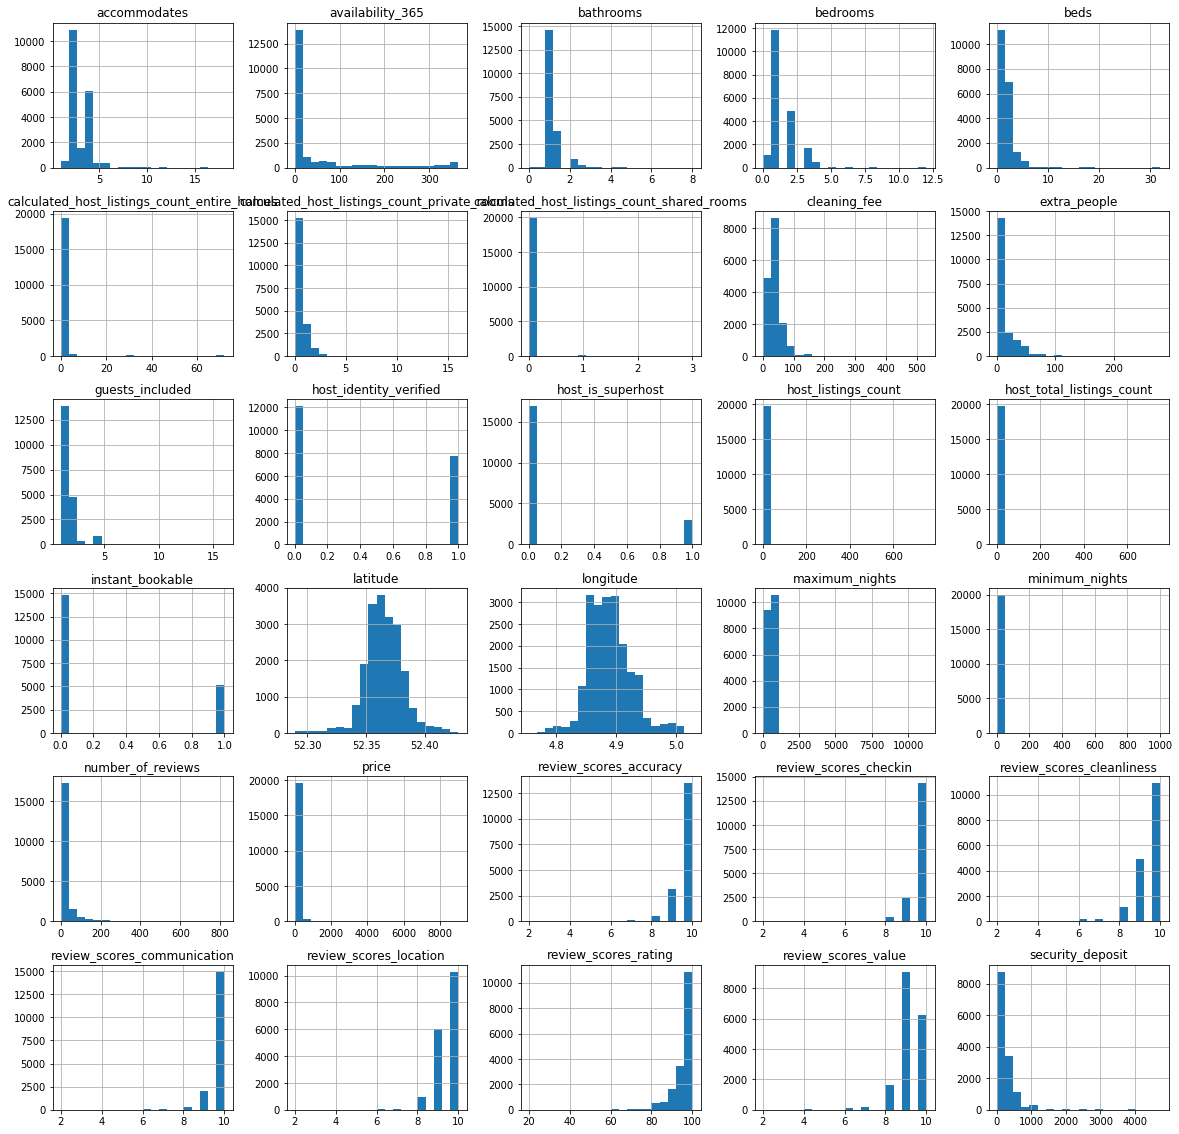

In [7]:
# Plotting the distribution of numerical and boolean categories (matplotlib)
df.hist(figsize=(20,20), bins=20);

# Other data cleaning steps

Er is een tabel 'host since', die de datum bevat waarop een host zich registreerde op Airbnb. Voor verdere analyse is het handiger om deze datum te vervangen door het aantal dagen geleden. Onbekende waarden kunnen worden vervangen door de mediaan. 

In [8]:
# Host since to datetime
# datetime to 'host_days_active'
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 12, 8) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())
print("Min days as host:", df['host_days_active'].min())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1711.0
Median days as host: 1764.0
Min days as host: 2.0


Hetzelfde voor aantal dagen sinds eerste review:

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_days_active,days_since_first_review,days_since_first_first_review
0,2008-09-24,within an hour,100%,1.0,1.0,1.0,0.0,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",59.0,200.0,60.0,1,20.0,3,15,0,277,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,1,0,4092.0,3905.0,Slumbering
1,2009-12-02,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-Oost,52.36509,4.89354,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Paid parking off premises"",...",80.0,NaN,NaN,2,0.0,1,1000,198,306,2010-03-02,2019-12-05,89.0,10.0,10.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,2,0,3658.0,3568.0,Slumbering
2,2009-11-20,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",125.0,300.0,40.0,2,10.0,14,60,71,3,2018-01-21,2019-05-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,2,0,0,3670.0,686.0,Very active
3,2010-03-23,within an hour,100%,1.0,1.0,1.0,1.0,Centrum-West,52.38673,4.89208,Houseboat,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Breakfast,Heating,""Smoke det...",155.0,0.0,0.0,1,0.0,2,730,251,206,2012-01-09,2019-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,1,0,3547.0,2890.0,Slumbering
4,2010-05-13,within an hour,100%,1.0,3.0,3.0,1.0,Centrum-West,52.36719,4.89092,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Ca...",75.0,NaN,NaN,1,0.0,2,1825,134,318,2010-08-22,2019-11-23,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,3,0,3496.0,3395.0,Slumbering


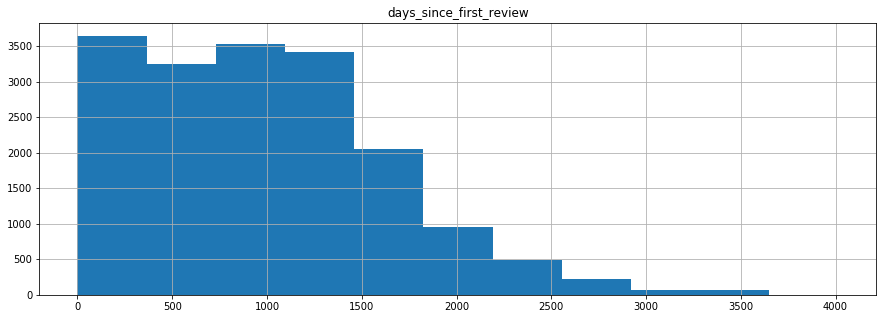

In [9]:
# Datum van first review to datetime,
# convert to number of days since first review 
df['first_review'] = pd.to_datetime(df['first_review']) 

# Calculating the number of days
df['days_since_first_review'] = (datetime(2019, 12, 8) - df['first_review']).astype('timedelta64[D]')


# Printing descriptives
df.hist(['days_since_first_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365

#DOING Binning time since last review
# Thanks to https://pbpython.com/pandas-qcut-cut.html
#print(pd.qcut(df['days_since_first_review'], q=5).value_counts())
df['days_since_first_first_review'] = pd.qcut(df['days_since_first_review'],
                              q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])
df.head()




En nogmaals voor het aantal dagen sinds laatste review:

count    17621.0
mean       359.0
std        406.0
min         29.0
25%         71.0
50%        155.0
75%        527.0
max       2720.0
Name: days_since_last_review, dtype: float64
(60.0, 113.0]      3585
(28.999, 60.0]     3541
(685.0, 2720.0]    3524
(234.0, 685.0]     3520
(113.0, 234.0]     3451
Name: days_since_last_review, dtype: int64


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_days_active,days_since_first_review,days_since_first_first_review,days_since_last_review,days_since_last_review_bin
0,2008-09-24,within an hour,100%,1.0,1.0,1.0,0.0,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",59.0,200.0,60.0,1,20.0,3,15,0,277,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,1,0,4092.0,3905.0,Slumbering,46.0,Extremely active
1,2009-12-02,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-Oost,52.36509,4.89354,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Paid parking off premises"",...",80.0,NaN,NaN,2,0.0,1,1000,198,306,2010-03-02,2019-12-05,89.0,10.0,10.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,2,0,3658.0,3568.0,Slumbering,32.0,Extremely active
2,2009-11-20,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",125.0,300.0,40.0,2,10.0,14,60,71,3,2018-01-21,2019-05-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,2,0,0,3670.0,686.0,Very active,240.0,Inactive
3,2010-03-23,within an hour,100%,1.0,1.0,1.0,1.0,Centrum-West,52.38673,4.89208,Houseboat,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Breakfast,Heating,""Smoke det...",155.0,0.0,0.0,1,0.0,2,730,251,206,2012-01-09,2019-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,1,0,3547.0,2890.0,Slumbering,56.0,Extremely active
4,2010-05-13,within an hour,100%,1.0,3.0,3.0,1.0,Centrum-West,52.36719,4.89092,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Ca...",75.0,NaN,NaN,1,0.0,2,1825,134,318,2010-08-22,2019-11-23,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,3,0,3496.0,3395.0,Slumbering,44.0,Extremely active


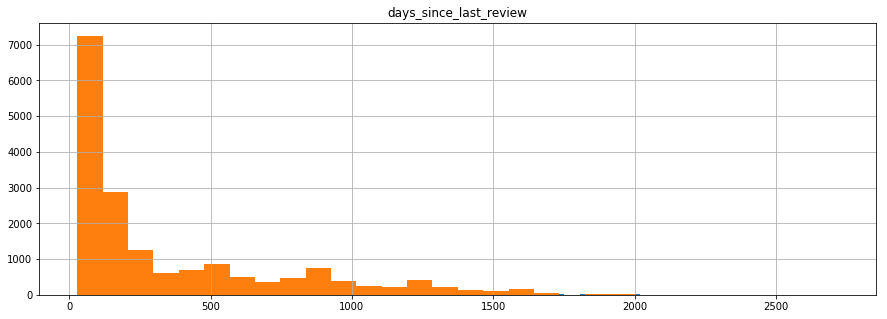

In [10]:
# Converting to datetime
df['last_review'] = pd.to_datetime(df['last_review']) 

# Calculating the number of days
df['days_since_last_review'] = (datetime(2020, 1, 6) - df['last_review']).astype('timedelta64[D]')

# Printing descriptives
print(df['days_since_last_review'].describe().round(decimals=0))
df.hist(['days_since_last_review'], bins=50)

# Distribution of the number of days since last review
df.days_since_last_review.hist(figsize=(15,5), bins=30);

#DOING Binning time since last review
# Thanks to https://pbpython.com/pandas-qcut-cut.html
print(pd.qcut(df['days_since_last_review'], q=5).value_counts())

df['days_since_last_review_bin'] = pd.qcut(df['days_since_last_review'],
                              q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])
df.head()
#TODO Remove slumbering accounts?

Er zijn veel missende waardes voor 'Host response time': hoe snel een host reageert op een bericht. Maar liefst 47% heeft hier geen waarde voor, wat teveel is om weg te gooien:

In [11]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

Null values: 9349
Proportion: 46.7%


unknown               0.466866
within an hour        0.265268
within a few hours    0.129238
within a day          0.119900
a few days or more    0.018727
Name: host_response_time, dtype: float64

In plaats daarvan converteren we  de getallen in 'host_response_rate' naar 4 categoriien, en zetten we alle missende waardes in een aparte categorie "Unknown". 

In [12]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.2%


unknown    9349
100%       8351
50-89%     1462
0-49%       549
90-99%      314
Name: host_response_rate, dtype: int64

Accomodaties met missende waardes voor 'Last review' kunnen we wel weggooien:

In [13]:
df.dropna(subset=['host_since'], inplace=True)
df.isna().sum()

host_since                                         0
host_response_time                                 0
host_response_rate                                 0
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_identity_verified                             0
neighbourhood                                      0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                          6
bedrooms                                          13
beds                                              31
bed_type                                           0
amenities                                          0
price                                         

C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


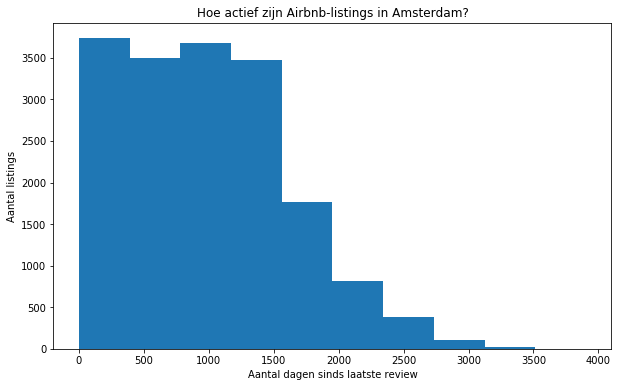

In [14]:
num_bins = 10

fig, ax = plt.subplots(figsize=(10, 6))
#ax  = plt.subplots(figsize=(20, 10))

# the histogram of the data
n, bins, patches = ax.hist(df['days_since_first_review'], num_bins)
ax.set_ylabel('Aantal listings')
ax.set_xlabel('Aantal dagen sinds laatste review')
ax.set_title('Hoe actief zijn Airbnb-listings in Amsterdam?')
plt.show()

In [15]:
df.head(25)

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_days_active,days_since_first_review,days_since_first_first_review,days_since_last_review,days_since_last_review_bin
0,2008-09-24,within an hour,100%,1.0,1.0,1.0,0.0,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",59.0,200.0,60.0,1,20.0,3,15,0,277,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,1,0,4092.0,3905.0,Slumbering,46.0,Extremely active
1,2009-12-02,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-Oost,52.36509,4.89354,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Paid parking off premises"",...",80.0,NaN,NaN,2,0.0,1,1000,198,306,2010-03-02,2019-12-05,89.0,10.0,10.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,2,0,3658.0,3568.0,Slumbering,32.0,Extremely active
2,2009-11-20,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",125.0,300.0,40.0,2,10.0,14,60,71,3,2018-01-21,2019-05-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,2,0,0,3670.0,686.0,Very active,240.0,Inactive
3,2010-03-23,within an hour,100%,1.0,1.0,1.0,1.0,Centrum-West,52.38673,4.89208,Houseboat,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Breakfast,Heating,""Smoke det...",155.0,0.0,0.0,1,0.0,2,730,251,206,2012-01-09,2019-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,1,0,3547.0,2890.0,Slumbering,56.0,Extremely active
4,2010-05-13,within an hour,100%,1.0,3.0,3.0,1.0,Centrum-West,52.36719,4.89092,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Ca...",75.0,NaN,NaN,1,0.0,2,1825,134,318,2010-08-22,2019-11-23,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,3,0,3496.0,3395.0,Slumbering,44.0,Extremely active
5,2010-05-13,within an hour,100%,1.0,3.0,3.0,1.0,Centrum-West,52.36773,4.89151,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Smoking allowed"",""Pets allowed...",55.0,NaN,NaN,1,0.0,2,730,0,467,2011-03-16,2019-11-26,95.0,10.0,10.0,10.0,10.0,10.0,9.0,0,moderate,0,3,0,3496.0,3189.0,Slumbering,41.0,Extremely active
6,2010-05-27,unknown,unknown,0.0,1.0,1.0,1.0,Zuid,52.35132,4.84838,Apartment,Entire home/apt,4,1.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",219.0,NaN,60.0,4,30.0,3,365,0,32,2011-08-06,2017-10-16,95.0,9.0,10.0,10.0,10.0,9.0,9.0,0,moderate,1,0,0,3482.0,3046.0,Slumbering,812.0,Slumbering
7,2010-07-23,within an hour,100%,1.0,1.0,1.0,1.0,Centrum-West,52.37891,4.88321,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",180.0,100.0,40.0,2,75.0,3,35,34,87,2010-11-25,2019-07-08,96.0,10.0,10.0,10.0,10.0,10.0,9.0,0,moderate,1,0,0,3425.0,3300.0,Slumbering,182.0,Active
9,2010-08-01,within a day,50-89%,0.0,1.0,1.0,1.0,Centrum-West,52.37537,4.88932,Apartment,Entire home/apt,4,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",210.0,NaN,35.0,2,60.0,3,30,0,821,2010-09-14,2019-11-29,98.0,10.0,10.0,8.0,10.0,10.0,8.0,0,moderate,1,0,0,3416.0,3372.0,Slumbering,38.0,Extremely active
10,2009-12-22,within a few hours,100%,0.0,1.0,1.0,0.0,Zuid,52

Missende waarden voor slaapkamers, bedden en badkamers worden vervangen door de mediaan. 

In [16]:
df.bed_type.value_counts()
df.drop('bed_type', axis=1, inplace=True)
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

Als een _fee_ geen waarde heeft, nemen we aan dat dit nul is:

In [17]:
# Security deposit set missing to zero
df.security_deposit.isna().sum()
df.security_deposit.fillna(0, inplace=True)

# Cleaning fee set missing to zero
df.cleaning_fee.isna().sum()
df.cleaning_fee.fillna(0, inplace=True)

# Extra people fee set missing to zero
df.extra_people.isna().sum()
df.extra_people.fillna(0, inplace=True)

Aantal property types: er zijn veel categorieen die erg klein zijn (en overspecifiek):

In [18]:
df.property_type.value_counts()

Apartment                 15116
House                      1653
Townhouse                   673
Bed and breakfast           413
Loft                        376
Condominium                 357
Boat                        333
Houseboat                   322
Guest suite                 157
Aparthotel                  111
Serviced apartment           67
Guesthouse                   48
Boutique hotel               42
Villa                        38
Hotel                        36
Hostel                       32
Other                        31
Tiny house                   14
Cabin                        13
Cottage                      12
Farm stay                     5
Bungalow                      4
Barn                          2
Chalet                        2
Yurt                          2
Island                        1
Campsite                      1
Camper/RV                     1
Lighthouse                    1
Tent                          1
Casa particular (Cuba)        1
Earth ho

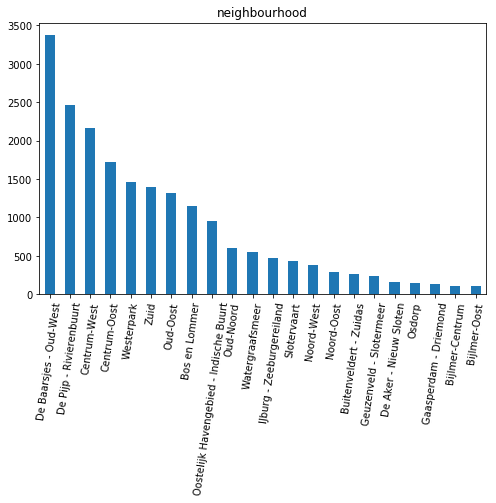

De Baarsjes - Oud-West                    0.169628
De Pijp - Rivierenbuurt                   0.123773
Centrum-West                              0.108723
Centrum-Oost                              0.086727
Westerpark                                0.073388
Zuid                                      0.070368
Oud-Oost                                  0.066190
Bos en Lommer                             0.057784
Oostelijk Havengebied - Indische Buurt    0.048321
Oud-Noord                                 0.030453
Watergraafsmeer                           0.027432
IJburg - Zeeburgereiland                  0.023859
Slotervaart                               0.021795
Noord-West                                0.019127
Noord-Oost                                0.014597
Buitenveldert - Zuidas                    0.013037
Geuzenveld - Slotermeer                   0.012030
De Aker - Nieuw Sloten                    0.007953
Osdorp                                    0.007248
Gaasperdam - Driemond          

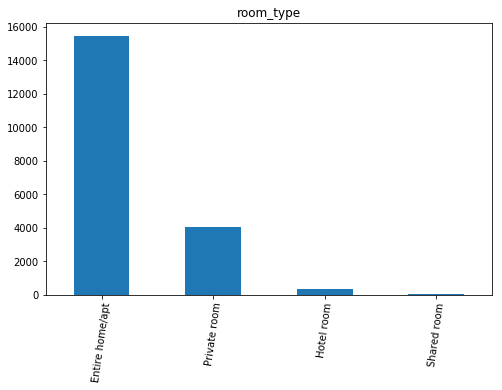

Entire home/apt    0.777923
Private room       0.203000
Hotel room         0.016258
Shared room        0.002819
Name: room_type, dtype: float64


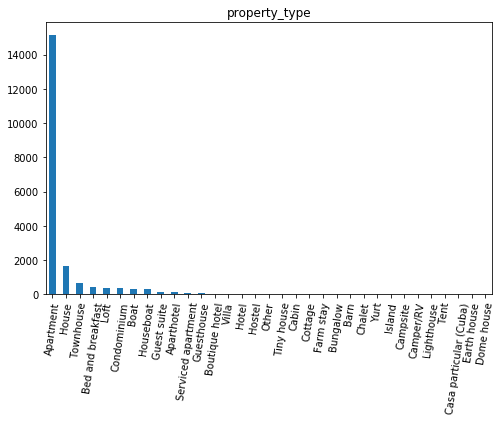

Apartment                 0.760860
House                     0.083203
Townhouse                 0.033875
Bed and breakfast         0.020788
Loft                      0.018926
Condominium               0.017969
Boat                      0.016761
Houseboat                 0.016208
Guest suite               0.007903
Aparthotel                0.005587
Serviced apartment        0.003372
Guesthouse                0.002416
Boutique hotel            0.002114
Villa                     0.001913
Hotel                     0.001812
Hostel                    0.001611
Other                     0.001560
Tiny house                0.000705
Cabin                     0.000654
Cottage                   0.000604
Farm stay                 0.000252
Bungalow                  0.000201
Barn                      0.000101
Chalet                    0.000101
Yurt                      0.000101
Island                    0.000050
Campsite                  0.000050
Camper/RV                 0.000050
Lighthouse          

In [19]:
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

In [20]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Bed and Breakfast': 'Hotel',
    'Loft': 'Apartment',
    'Condominium': 'Apartment',
    'Houseboat': 'Boat',
    'Guest suite': 'Apartment',
    'Aparthotel': 'Hotel',
    'Serviced apartment': 'Apartment',
    'Guesthouse': 'House',    
    'Boutique hotel': 'Hotel',
    'Villa': 'House',
    'Hostel': 'Hotel',
    'Tiny house': 'House',
    'Cabin': 'House',
    'Cottage': 'House',
    'Bungalow': 'House',
    'Chalet': 'House',
    'Earth house': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment','Hotel','Boat']), 'property_type'] = 'Other'

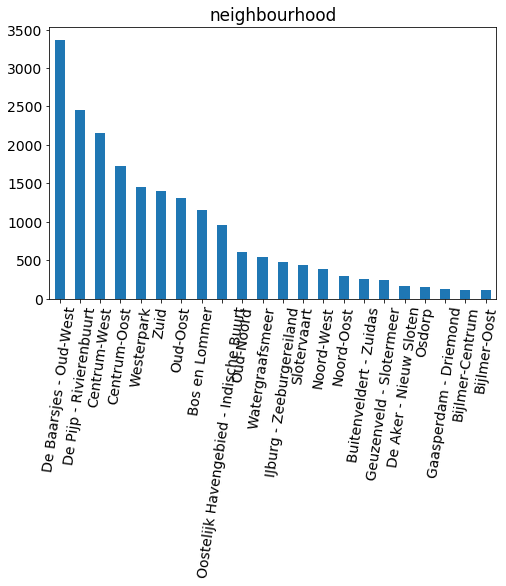

De Baarsjes - Oud-West                    0.169628
De Pijp - Rivierenbuurt                   0.123773
Centrum-West                              0.108723
Centrum-Oost                              0.086727
Westerpark                                0.073388
Zuid                                      0.070368
Oud-Oost                                  0.066190
Bos en Lommer                             0.057784
Oostelijk Havengebied - Indische Buurt    0.048321
Oud-Noord                                 0.030453
Watergraafsmeer                           0.027432
IJburg - Zeeburgereiland                  0.023859
Slotervaart                               0.021795
Noord-West                                0.019127
Noord-Oost                                0.014597
Buitenveldert - Zuidas                    0.013037
Geuzenveld - Slotermeer                   0.012030
De Aker - Nieuw Sloten                    0.007953
Osdorp                                    0.007248
Gaasperdam - Driemond          

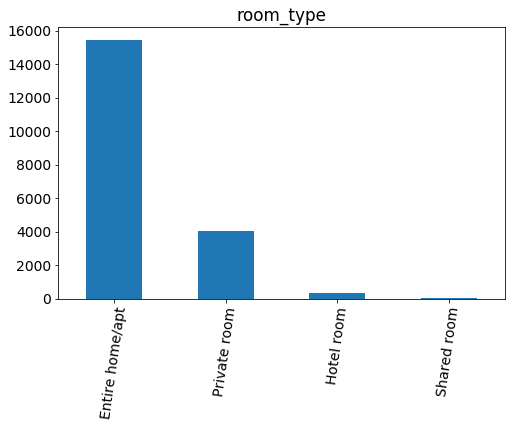

Entire home/apt    0.777923
Private room       0.203000
Hotel room         0.016258
Shared room        0.002819
Name: room_type, dtype: float64


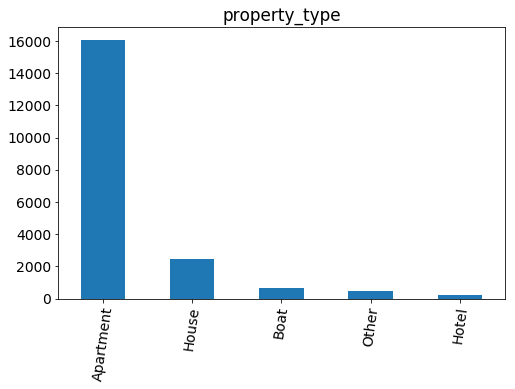

Apartment    0.809030
House        0.123723
Boat         0.032969
Other        0.023154
Hotel        0.011124
Name: property_type, dtype: float64


In [21]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

Amenities

In [22]:
#df.amenities[:1].replace({'{':''}).replace({'}':''}).replace({'"':''}).replace({'(':''}).replace({')':''}).replace({'/':''}).replace({'-':' '}).replace({'_':' '}).replace({':':' '}).replace({'’':''}).replace({'.':' '}).replace({'  ':' '})


In [23]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',') if x.strip()]
amenities_set = set(amenities_set)
amenities_set

{'24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Fl

In [24]:
#df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
len(df[df['amenities'].str.contains("Cat(s)", regex=False)])
unique_amenities = list(amenities_set)

657

In [27]:
# Create encoding for every amenity
for i in range(len(unique_amenities)):
    df.loc[df['amenities'].str.contains(unique_amenities[i], regex=False), unique_amenities[i]] = 1
    
df.head(30)

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_days_active,days_since_first_review,days_since_first_first_review,days_since_last_review,days_since_last_review_bin,Iron,Air conditioning,Paid parking off premises,Carbon monoxide detector,Roll-in shower with chair,Accessible-height bed,Ethernet connection,Cat(s),...,Hangers,Beachfront,Hair dryer,Internet,Smart lock,Wide entrance,Babysitter recommendations,Bathtub,Dog(s),Pocket wifi,Children’s books and toys,Shower gel,Changing table,Building staff,Hot water,Wide entrance for guests,First aid kit,Smoking allowed,Extra space around bed,Kitchen,Indoor fireplace,Cooking basics,Baby bath,Stair gates,Dishwasher,Trash can,Safety card,Paid parking on premises,Family/kid friendly,Private entrance,Disabled parking spot,Oven,Fixed grab bars for shower,Mobile hoist,Other,Garden or backyard,Children’s dinnerware,Dryer,High chair,Ground floor access,Wheelchair accessible,No stairs or steps to enter,Waterfront,Elevator,Pack ’n Play/travel crib,Wide doorway to guest bathroom,Full kitchen,Wide entryway,Firm mattress,Patio or balcony,Pets allowed,Pets live on this property,Washer
0,2008-09-24,within an hour,100%,1.0,1.0,1.0,0.0,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,2,1.5,1.0,2.0,"{Internet,Wifi,""Paid parking off premises"",""Bu...",59.0,200.0,60.0,1,20.0,3,15,0,277,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,1,0,4092.0,3905.0,Slumbering,46.0,Extremely active,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2009-12-02,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-Oost,52.36509,4.89354,House,Private room,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",80.0,0.0,0.0,2,0.0,1,1000,198,306,2010-03-02,2019-12-05,89.0,10.0,10.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,2,0,3658.0,3568.0,Slumbering,32.0,Extremely active,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-11-20,within an hour,100%,0.0,2.0,2.0,0.0,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",125.0,300.0,40.0,2,10.0,14,60,71,3,2018-01-21,2019-05-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,2,0,0,3670.0,686.0,Very active,240.0,Inactive,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2010-03-23,within an hour,100%,1.0,1.0,1.0,1.0,Centrum-West,52.38673,4.89208,Boat,Private room,2,1.0,1.0,1.0,"{TV,Internet,Wifi,Breakfast,Heating,""Smoke det...",155.0,0.0,0.0,1,0.0,2,730,251,206,2012-01-09,2019-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,1,0,3547.0,2890.0,Slumbering,56.0,Extremely active,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,1.0,1

In [29]:
# Check
print(len(df[df['amenities'].str.contains("charger")])) # 294
print(df['EV charger'].sum(axis=0, skipna=True)) # 294

print(len(df[df['amenities'].str.contains("Cat")])) # 657
print(df['Cat(s)'].sum(axis=0, skipna=True)) # 657

294
294.0
657
657.0


Index(['days_since_last_review', 'days_since_last_review_bin', 'Iron',
       'Air conditioning', 'Paid parking off premises',
       'Carbon monoxide detector', 'Roll-in shower with chair',
       'Accessible-height bed', 'Ethernet connection', 'Cat(s)',
       ...
       'Elevator', 'Pack ’n Play/travel crib',
       'Wide doorway to guest bathroom', 'Full kitchen', 'Wide entryway',
       'Firm mattress', 'Patio or balcony', 'Pets allowed',
       'Pets live on this property', 'Washer'],
      dtype='object', length=134)

In [31]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,45:].columns
cols_to_replace_nulls
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

## Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

In [32]:
# Save clean data to csv
print(f"The dataset contains {len(df)} Airbnb listings")
df.to_csv(r'airbnb_clean.csv', index=False)

The dataset contains 19867 Airbnb listings


# Exploration / visualiation (no changes to data beyond this point)

Geographic information, 

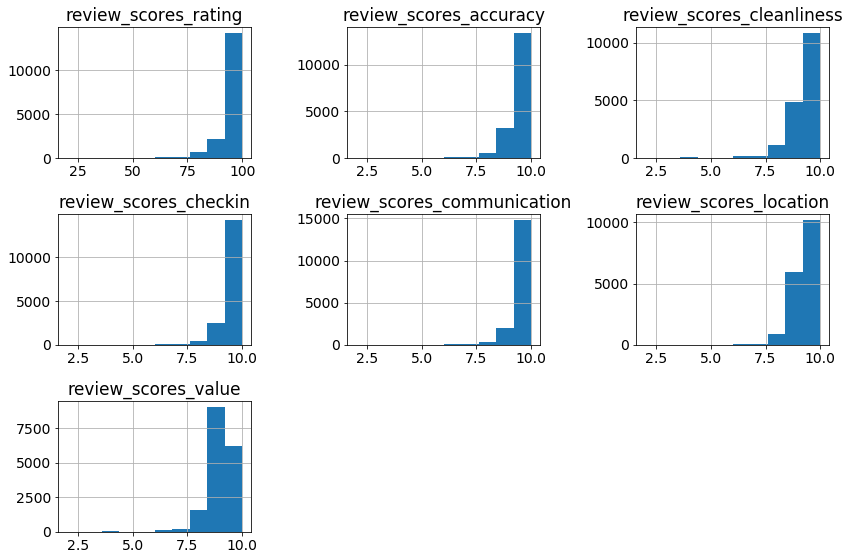

In [33]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [34]:
# GEO
# Importing the Amsterdam neighbourhood  GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('http://klaasjan.eu/files/airbnb/neighbourhoods.geojson')
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)
map_df.head(20)

,neighbourhood,geometry
0,Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."
5,Centrum-West,"MULTIPOLYGON Z (((4.90640 52.38004 42.97078, 4..."
6,Oostelijk Havengebied - Indische Buurt,"MULTIPOLYGON Z (((4.96131 52.35913 43.00823, 4..."
7,Centrum-Oost,"MULTIPOLYGON Z (((4.93297 52.37041 42.98810, 4..."
8,Oud-Oost,"MULTIPOLYGON Z (((4.93743 52.35774 43.01043, 4..."
9,Watergraafsmeer,"MULTIPOLYGON Z (((4.96971 52.35636 43.01317, 4..."


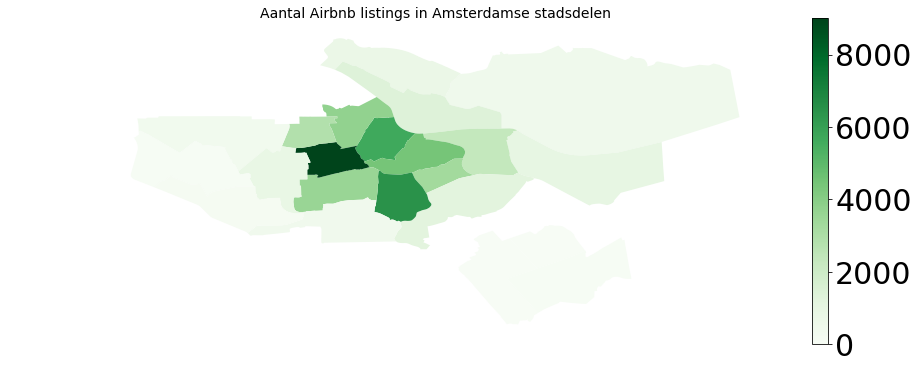

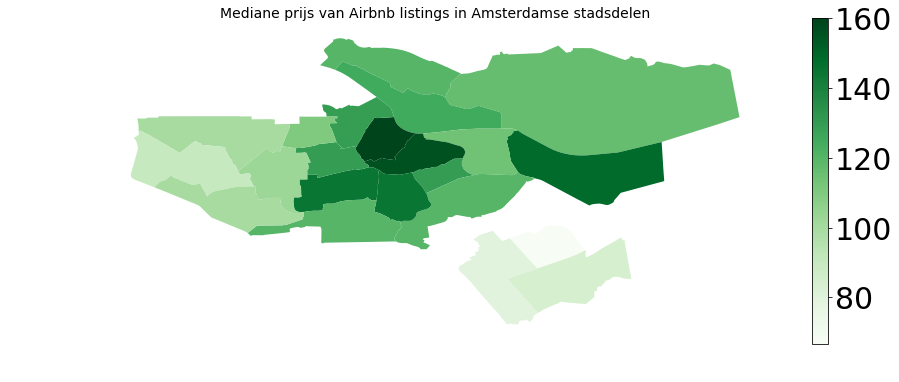

                                        number_of_listings  median_price
neighbourhood                                                           
Bijlmer-Centrum                                        113          80.0
Bijlmer-Oost                                           106          66.5
Bos en Lommer                                         1148         110.0
Buitenveldert - Zuidas                                 259         120.0
Centrum-Oost                                          1723         156.0
Centrum-West                                          2160         160.0
De Aker - Nieuw Sloten                                 158         100.0
De Baarsjes - Oud-West                                3370         130.0
De Pijp - Rivierenbuurt                               2459         145.0
Gaasperdam - Driemond                                  130          84.5
Geuzenveld - Slotermeer                                239         100.0
IJburg - Zeeburgereiland                           

In [35]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(df.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = df.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = map_df.set_index('neighbourhood').join(neighbourhood_df)
                  
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Greens', ax=ax1, rasterized=True,)


ax1.axis('off')
ax1.set_title('Aantal Airbnb listings in Amsterdamse stadsdelen', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Greens', ax=ax2)
ax2.axis('off')
ax2.set_title('Mediane prijs van Airbnb listings in Amsterdamse stadsdelen', fontsize=14)#
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()
print(neighbourhood_df)

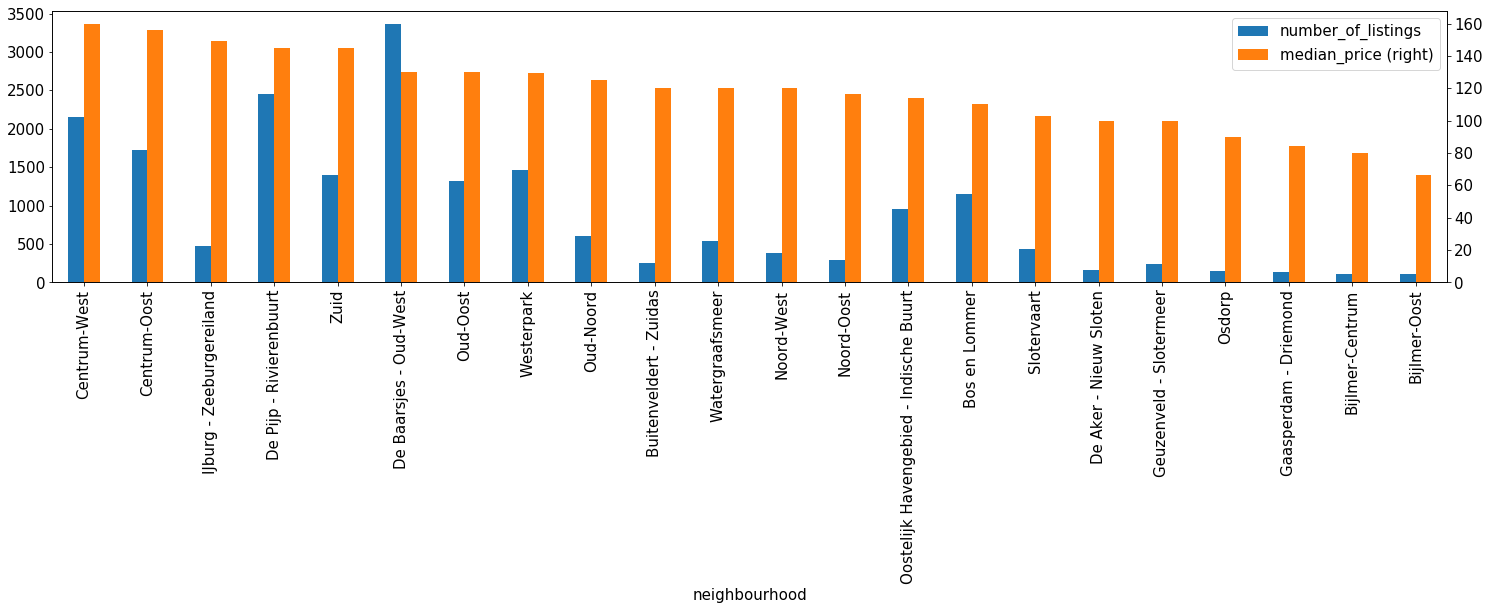

In [37]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
neighbourhood_df_sorted = neighbourhood_df.sort_values('median_price', ascending=False)
neighbourhood_df_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')

plt.show()

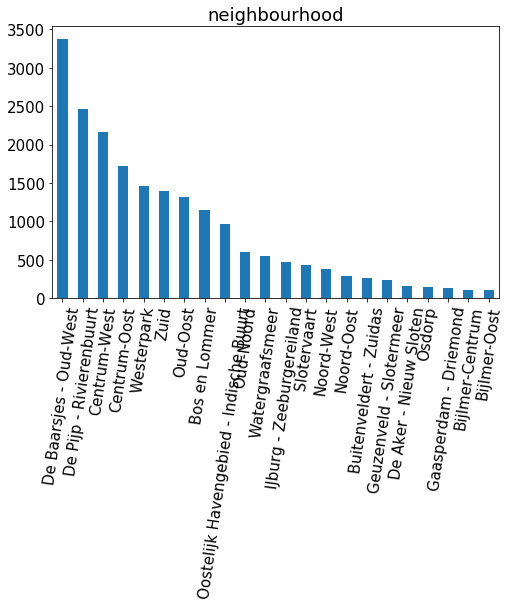

De Baarsjes - Oud-West                    0.169628
De Pijp - Rivierenbuurt                   0.123773
Centrum-West                              0.108723
Centrum-Oost                              0.086727
Westerpark                                0.073388
Zuid                                      0.070368
Oud-Oost                                  0.066190
Bos en Lommer                             0.057784
Oostelijk Havengebied - Indische Buurt    0.048321
Oud-Noord                                 0.030453
Watergraafsmeer                           0.027432
IJburg - Zeeburgereiland                  0.023859
Slotervaart                               0.021795
Noord-West                                0.019127
Noord-Oost                                0.014597
Buitenveldert - Zuidas                    0.013037
Geuzenveld - Slotermeer                   0.012030
De Aker - Nieuw Sloten                    0.007953
Osdorp                                    0.007248
Gaasperdam - Driemond          

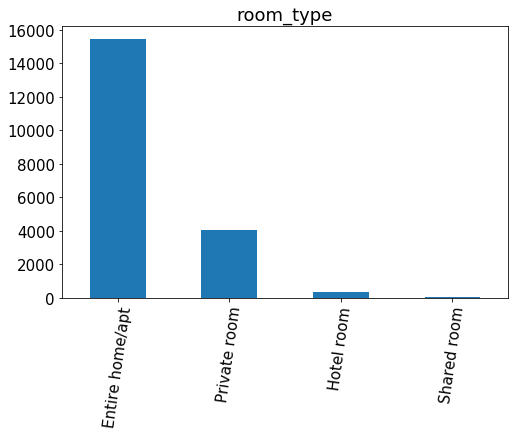

Entire home/apt    0.777923
Private room       0.203000
Hotel room         0.016258
Shared room        0.002819
Name: room_type, dtype: float64


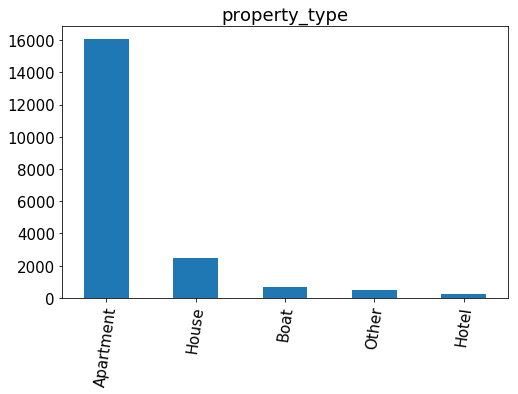

Apartment    0.809030
House        0.123723
Boat         0.032969
Other        0.023154
Hotel        0.011124
Name: property_type, dtype: float64


In [38]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 250, 50
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

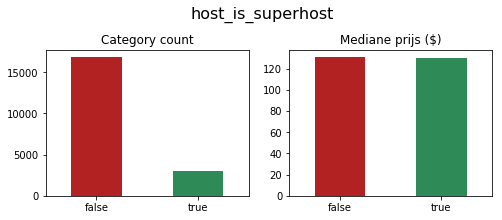

P-value is 2.00e-01
There are 16853 without host_is_superhost, with a median price of 131.0
There are 3014 with host_is_superhost, with a median price of 130.0
0.0    0.848291
1.0    0.151709
Name: host_is_superhost, dtype: float64


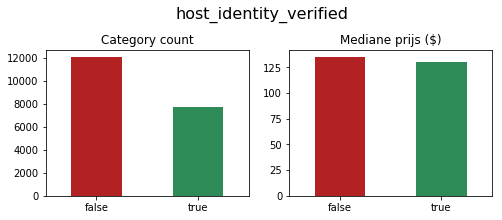

P-value is 9.65e-02
There are 12094 without host_identity_verified, with a median price of 135.0
There are 7773 with host_identity_verified, with a median price of 130.0


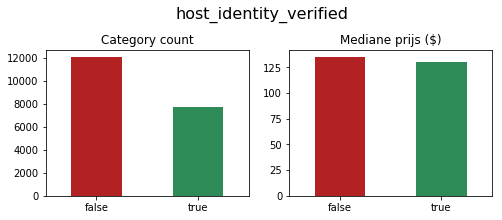

P-value is 9.65e-02
There are 12094 without host_identity_verified, with a median price of 135.0
There are 7773 with host_identity_verified, with a median price of 130.0


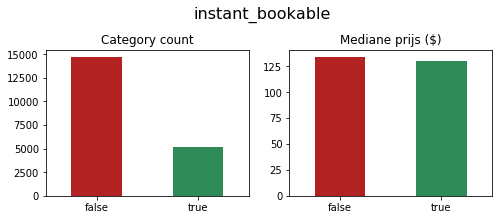

P-value is 1.95e-06
There are 14716 without instant_bookable, with a median price of 134.0
There are 5151 with instant_bookable, with a median price of 130.0
Effect is significant!
0    0.740726
1    0.259274
Name: instant_bookable, dtype: float64


In [44]:
superhost = binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
binary_count_and_price_plot('host_identity_verified')

test3 = binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))


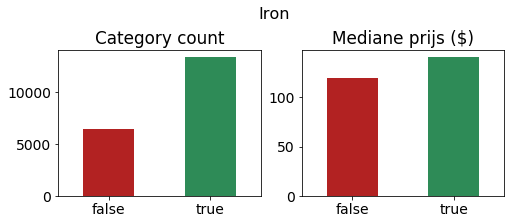

P-value is 1.21e-17
There are 6443 without Iron, with a median price of 120.0
There are 13424 with Iron, with a median price of 141.0
Effect is significant!


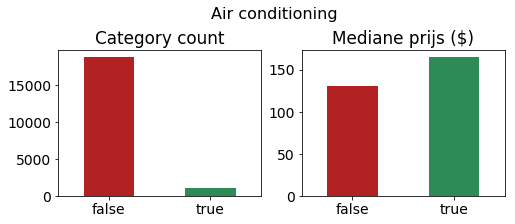

P-value is 8.77e-42
There are 18845 without Air conditioning, with a median price of 130.0
There are 1022 with Air conditioning, with a median price of 165.0
Effect is significant!


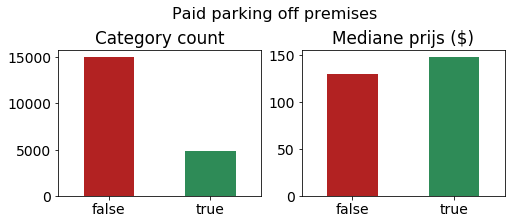

P-value is 1.32e-04
There are 15039 without Paid parking off premises, with a median price of 130.0
There are 4828 with Paid parking off premises, with a median price of 148.0
Effect is significant!


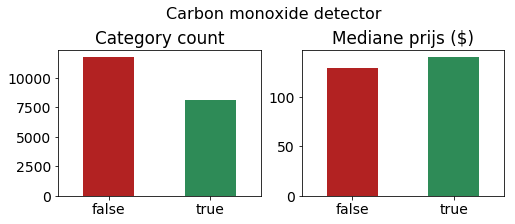

P-value is 7.47e-09
There are 11764 without Carbon monoxide detector, with a median price of 129.0
There are 8103 with Carbon monoxide detector, with a median price of 140.0
Effect is significant!


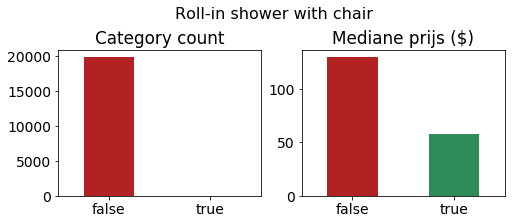

P-value is    nan
There are 19866 without Roll-in shower with chair, with a median price of 130.0
There are 1 with Roll-in shower with chair, with a median price of 58.0


C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


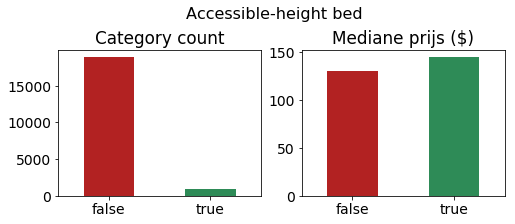

P-value is 1.53e-01
There are 18926 without Accessible-height bed, with a median price of 130.0
There are 941 with Accessible-height bed, with a median price of 145.0


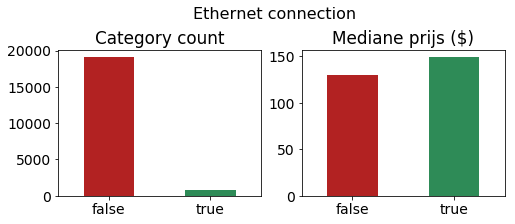

P-value is 2.06e-01
There are 19120 without Ethernet connection, with a median price of 130.0
There are 747 with Ethernet connection, with a median price of 149.0


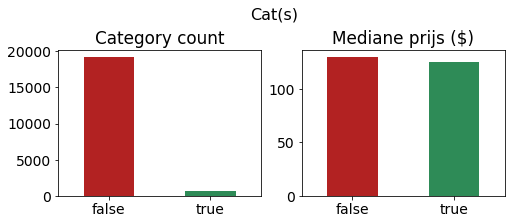

P-value is 3.73e-01
There are 19210 without Cat(s), with a median price of 130.0
There are 657 with Cat(s), with a median price of 125.0


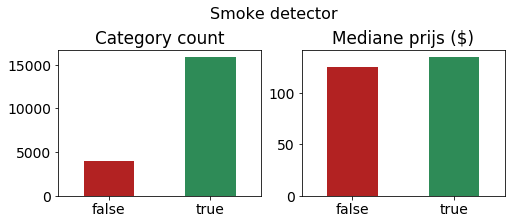

P-value is 7.03e-08
There are 3966 without Smoke detector, with a median price of 125.0
There are 15901 with Smoke detector, with a median price of 135.0
Effect is significant!


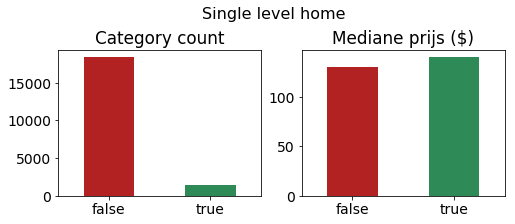

P-value is 4.98e-01
There are 18434 without Single level home, with a median price of 130.0
There are 1433 with Single level home, with a median price of 140.0


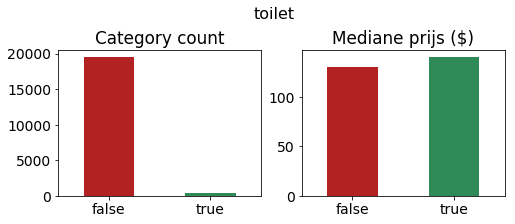

P-value is 2.42e-01
There are 19518 without toilet, with a median price of 130.0
There are 349 with toilet, with a median price of 140.0


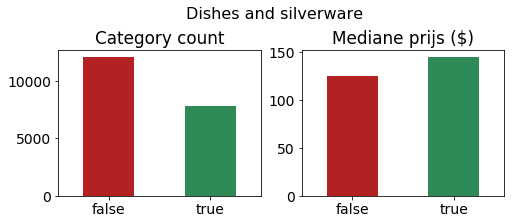

P-value is 1.91e-05
There are 12060 without Dishes and silverware, with a median price of 125.0
There are 7807 with Dishes and silverware, with a median price of 145.0
Effect is significant!


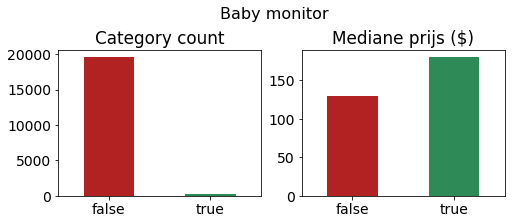

P-value is 2.09e-07
There are 19601 without Baby monitor, with a median price of 130.0
There are 266 with Baby monitor, with a median price of 180.0
Effect is significant!


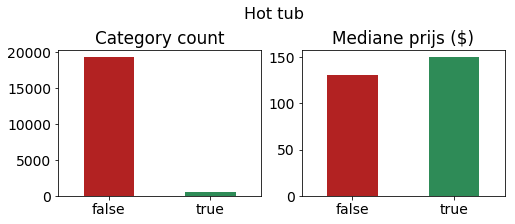

P-value is 1.09e-08
There are 19361 without Hot tub, with a median price of 130.0
There are 506 with Hot tub, with a median price of 150.0
Effect is significant!


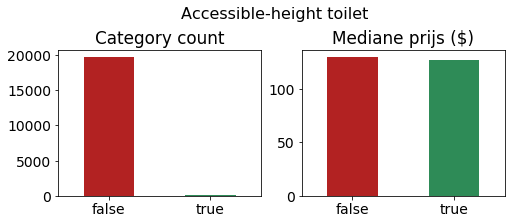

P-value is 4.97e-01
There are 19745 without Accessible-height toilet, with a median price of 130.0
There are 122 with Accessible-height toilet, with a median price of 127.5


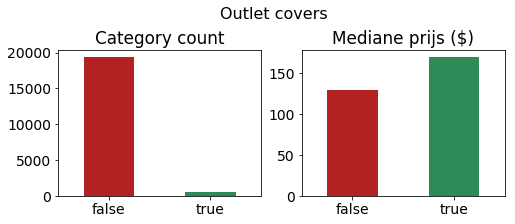

P-value is 1.25e-04
There are 19387 without Outlet covers, with a median price of 130.0
There are 480 with Outlet covers, with a median price of 170.0
Effect is significant!


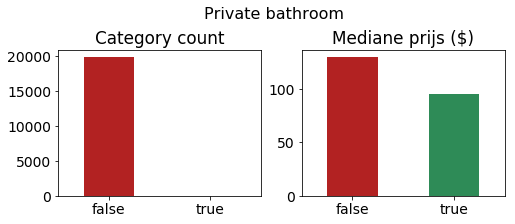

P-value is 6.28e-01
There are 19865 without Private bathroom, with a median price of 130.0
There are 2 with Private bathroom, with a median price of 95.0


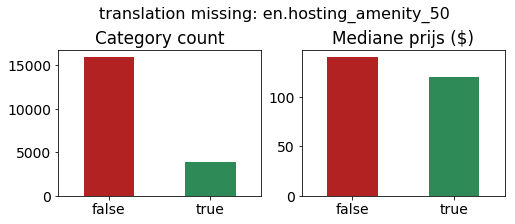

P-value is 2.45e-24
There are 15968 without translation missing: en.hosting_amenity_50, with a median price of 140.0
There are 3899 with translation missing: en.hosting_amenity_50, with a median price of 120.0
Effect is significant!


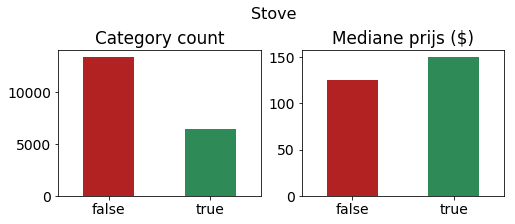

P-value is 6.21e-11
There are 13419 without Stove, with a median price of 125.0
There are 6448 with Stove, with a median price of 150.0
Effect is significant!


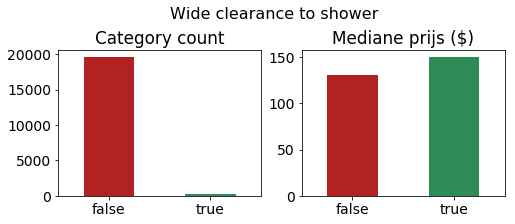

P-value is 7.20e-02
There are 19600 without Wide clearance to shower, with a median price of 130.0
There are 267 with Wide clearance to shower, with a median price of 150.0


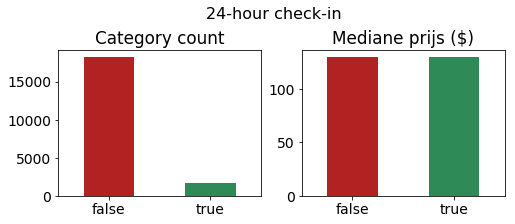

P-value is 2.18e-01
There are 18233 without 24-hour check-in, with a median price of 130.0
There are 1634 with 24-hour check-in, with a median price of 130.0


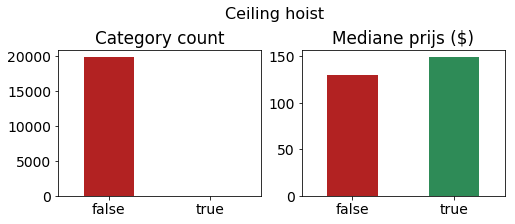

P-value is 9.20e-01
There are 19865 without Ceiling hoist, with a median price of 130.0
There are 2 with Ceiling hoist, with a median price of 149.0


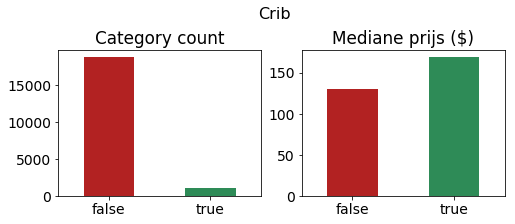

P-value is 5.46e-13
There are 18782 without Crib, with a median price of 130.0
There are 1085 with Crib, with a median price of 169.0
Effect is significant!


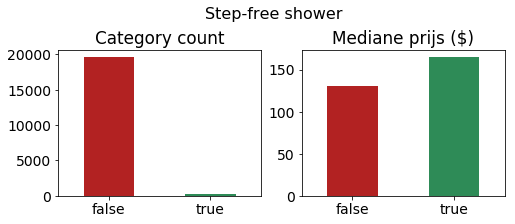

P-value is 6.44e-02
There are 19637 without Step-free shower, with a median price of 130.0
There are 230 with Step-free shower, with a median price of 165.0


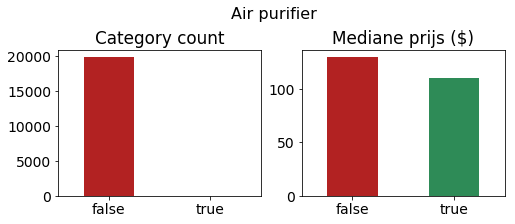

P-value is 8.52e-01
There are 19864 without Air purifier, with a median price of 130.0
There are 3 with Air purifier, with a median price of 110.0


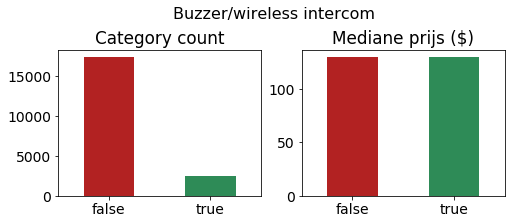

P-value is 5.76e-02
There are 17339 without Buzzer/wireless intercom, with a median price of 130.0
There are 2528 with Buzzer/wireless intercom, with a median price of 130.0


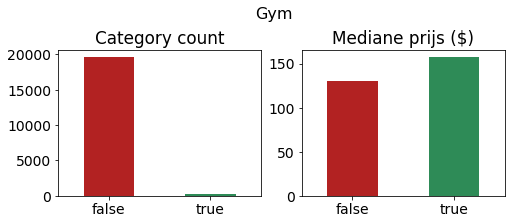

P-value is 1.87e-11
There are 19623 without Gym, with a median price of 130.0
There are 244 with Gym, with a median price of 157.5
Effect is significant!


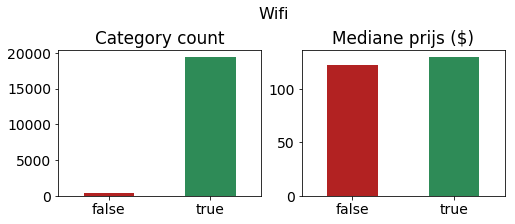

P-value is 1.89e-01
There are 448 without Wifi, with a median price of 122.5
There are 19419 with Wifi, with a median price of 130.0


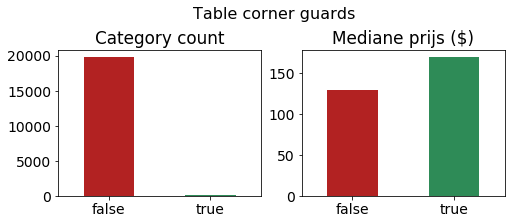

P-value is 1.40e-02
There are 19800 without Table corner guards, with a median price of 130.0
There are 67 with Table corner guards, with a median price of 170.0


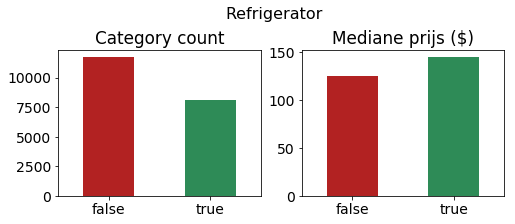

P-value is 6.19e-10
There are 11741 without Refrigerator, with a median price of 125.0
There are 8126 with Refrigerator, with a median price of 145.0
Effect is significant!


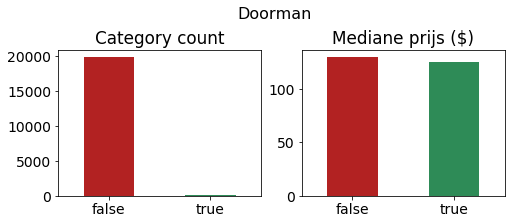

P-value is 5.77e-01
There are 19814 without Doorman, with a median price of 130.0
There are 53 with Doorman, with a median price of 125.0


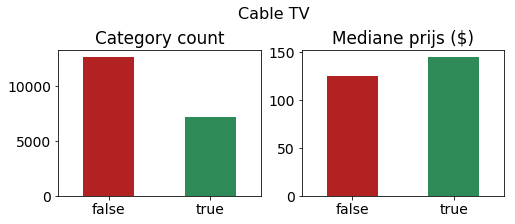

P-value is 1.43e-15
There are 12697 without Cable TV, with a median price of 125.0
There are 7170 with Cable TV, with a median price of 145.0
Effect is significant!


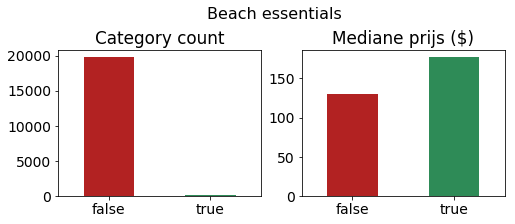

P-value is 1.60e-01
There are 19797 without Beach essentials, with a median price of 130.0
There are 70 with Beach essentials, with a median price of 177.5


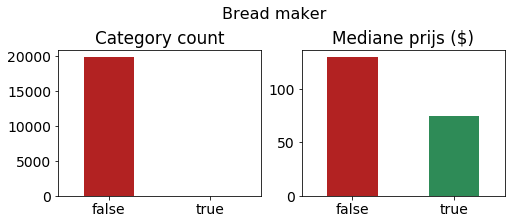

P-value is    nan
There are 19866 without Bread maker, with a median price of 130.0
There are 1 with Bread maker, with a median price of 75.0


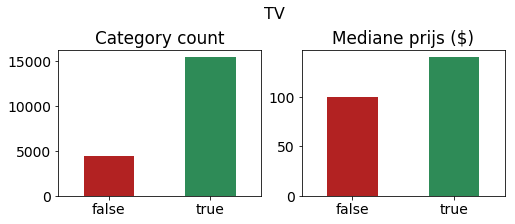

P-value is 4.12e-37
There are 4395 without TV, with a median price of 100.0
There are 15472 with TV, with a median price of 140.0
Effect is significant!


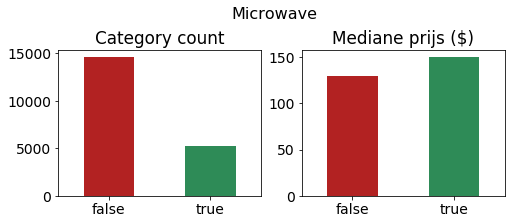

P-value is 5.42e-12
There are 14601 without Microwave, with a median price of 129.0
There are 5266 with Microwave, with a median price of 150.0
Effect is significant!


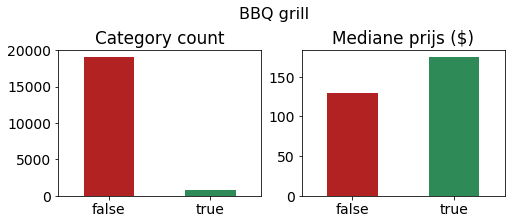

P-value is 6.27e-08
There are 19062 without BBQ grill, with a median price of 130.0
There are 805 with BBQ grill, with a median price of 175.0
Effect is significant!


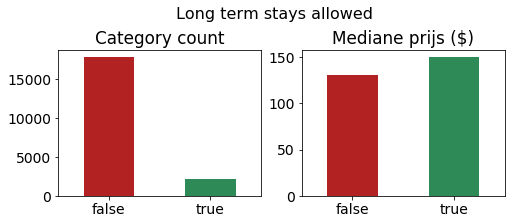

P-value is 6.19e-20
There are 17779 without Long term stays allowed, with a median price of 130.0
There are 2088 with Long term stays allowed, with a median price of 150.0
Effect is significant!


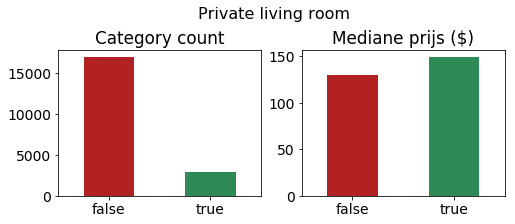

P-value is 3.87e-05
There are 16970 without Private living room, with a median price of 130.0
There are 2897 with Private living room, with a median price of 149.0
Effect is significant!


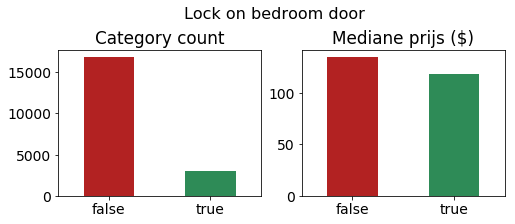

P-value is 9.08e-01
There are 16869 without Lock on bedroom door, with a median price of 135.0
There are 2998 with Lock on bedroom door, with a median price of 118.0


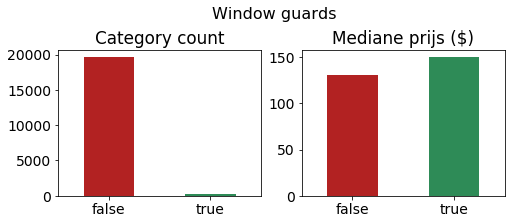

P-value is 1.38e-02
There are 19655 without Window guards, with a median price of 130.0
There are 212 with Window guards, with a median price of 150.0


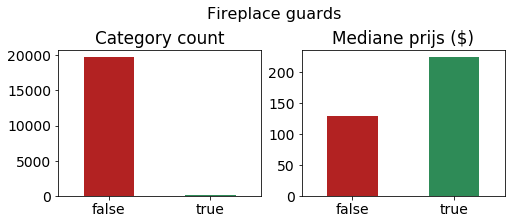

P-value is 3.44e-09
There are 19776 without Fireplace guards, with a median price of 130.0
There are 91 with Fireplace guards, with a median price of 225.0
Effect is significant!


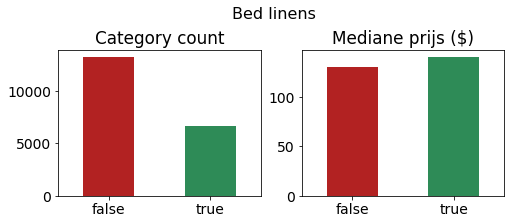

P-value is 3.43e-06
There are 13227 without Bed linens, with a median price of 130.0
There are 6640 with Bed linens, with a median price of 140.0
Effect is significant!


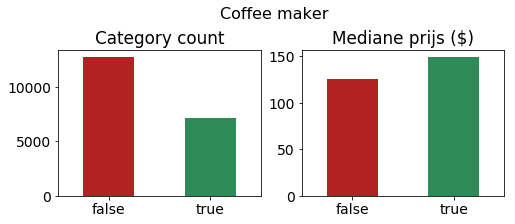

P-value is 2.24e-09
There are 12743 without Coffee maker, with a median price of 125.0
There are 7124 with Coffee maker, with a median price of 149.0
Effect is significant!


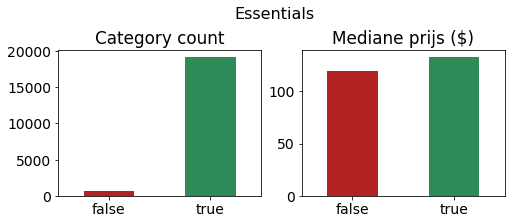

P-value is 3.17e-02
There are 664 without Essentials, with a median price of 120.0
There are 19203 with Essentials, with a median price of 133.0


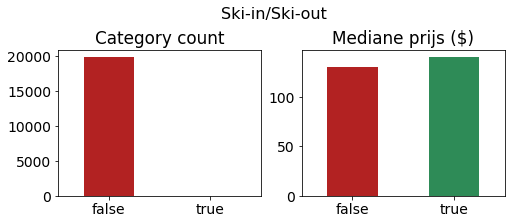

P-value is 5.87e-01
There are 19860 without Ski-in/Ski-out, with a median price of 130.0
There are 7 with Ski-in/Ski-out, with a median price of 140.0


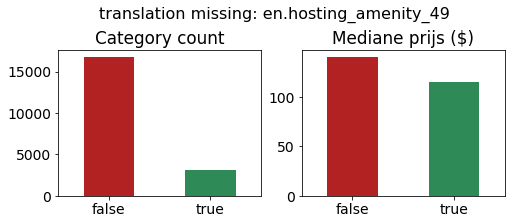

P-value is 2.06e-30
There are 16764 without translation missing: en.hosting_amenity_49, with a median price of 140.0
There are 3103 with translation missing: en.hosting_amenity_49, with a median price of 115.0
Effect is significant!


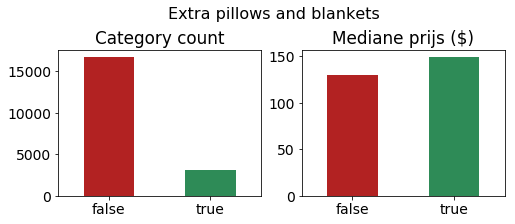

P-value is 9.71e-13
There are 16735 without Extra pillows and blankets, with a median price of 130.0
There are 3132 with Extra pillows and blankets, with a median price of 149.0
Effect is significant!


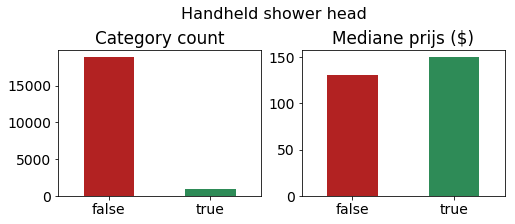

P-value is 1.64e-05
There are 18895 without Handheld shower head, with a median price of 130.0
There are 972 with Handheld shower head, with a median price of 150.0
Effect is significant!


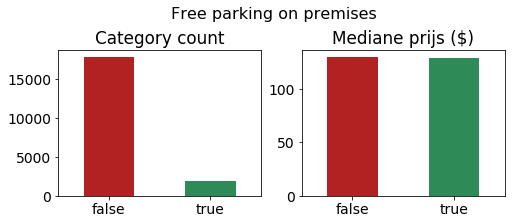

P-value is 9.15e-01
There are 17896 without Free parking on premises, with a median price of 130.0
There are 1971 with Free parking on premises, with a median price of 129.0


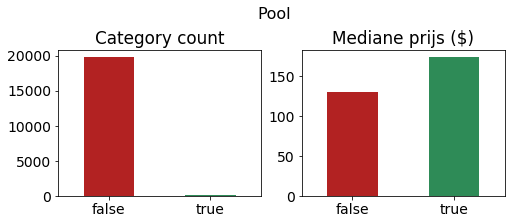

P-value is 9.43e-08
There are 19797 without Pool, with a median price of 130.0
There are 70 with Pool, with a median price of 174.5
Effect is significant!


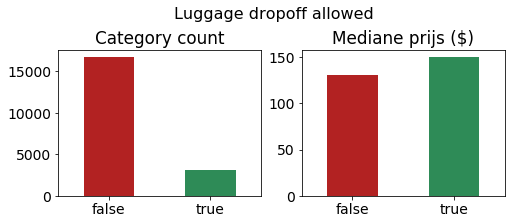

P-value is 8.07e-21
There are 16707 without Luggage dropoff allowed, with a median price of 130.0
There are 3160 with Luggage dropoff allowed, with a median price of 150.0
Effect is significant!


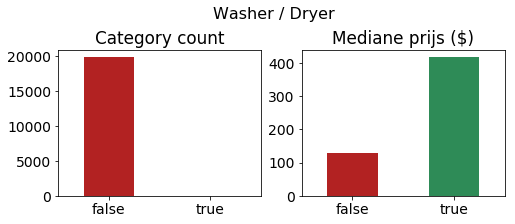

P-value is 7.10e-02
There are 19865 without Washer / Dryer, with a median price of 130.0
There are 2 with Washer / Dryer, with a median price of 417.5


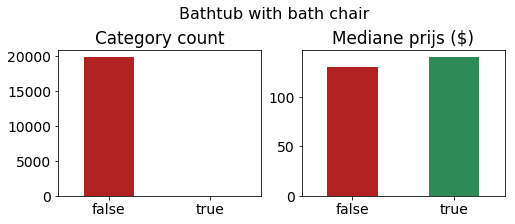

P-value is 3.06e-01
There are 19851 without Bathtub with bath chair, with a median price of 130.0
There are 16 with Bathtub with bath chair, with a median price of 140.0


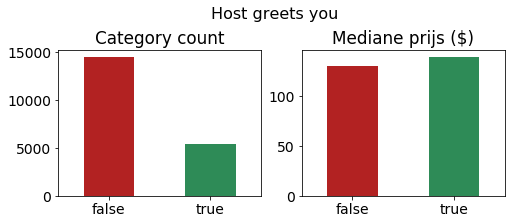

P-value is 3.84e-01
There are 14447 without Host greets you, with a median price of 130.0
There are 5420 with Host greets you, with a median price of 139.0


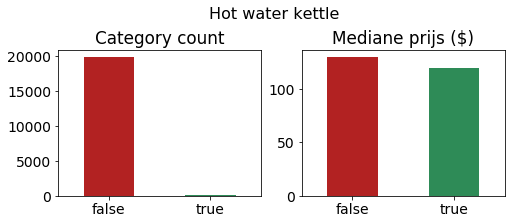

P-value is 4.66e-01
There are 19824 without Hot water kettle, with a median price of 130.0
There are 43 with Hot water kettle, with a median price of 120.0


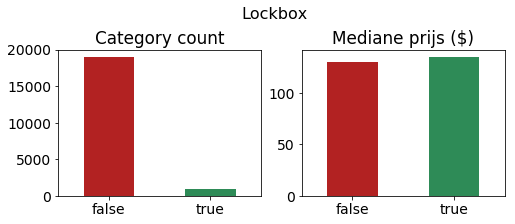

P-value is 2.99e-01
There are 18992 without Lockbox, with a median price of 130.0
There are 875 with Lockbox, with a median price of 135.0


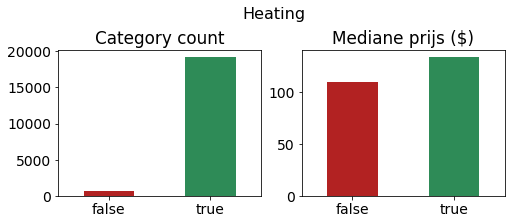

P-value is 7.82e-01
There are 646 without Heating, with a median price of 110.0
There are 19221 with Heating, with a median price of 134.0


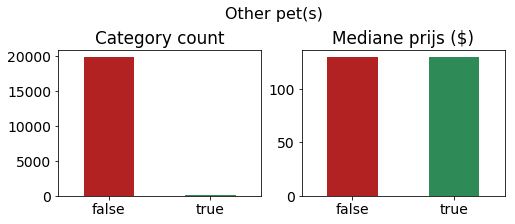

P-value is 6.29e-01
There are 19809 without Other pet(s), with a median price of 130.0
There are 58 with Other pet(s), with a median price of 130.0


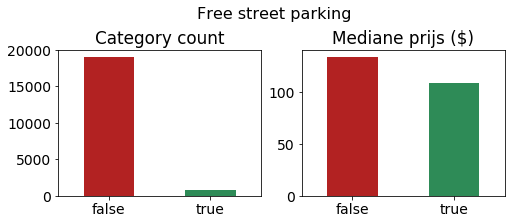

P-value is 1.23e-01
There are 19010 without Free street parking, with a median price of 134.0
There are 857 with Free street parking, with a median price of 109.0


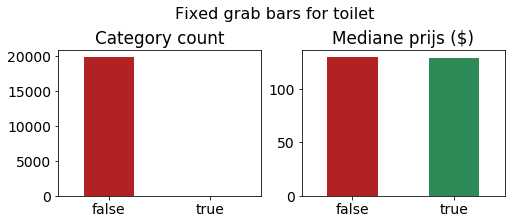

P-value is 6.78e-01
There are 19850 without Fixed grab bars for toilet, with a median price of 130.0
There are 17 with Fixed grab bars for toilet, with a median price of 129.0


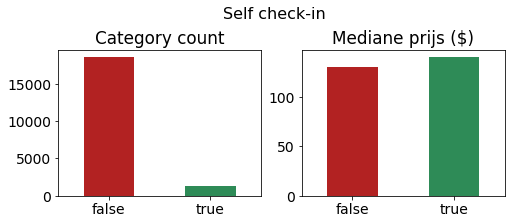

P-value is 6.65e-02
There are 18567 without Self check-in, with a median price of 130.0
There are 1300 with Self check-in, with a median price of 140.0


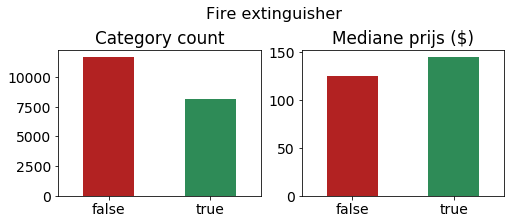

P-value is 1.06e-26
There are 11699 without Fire extinguisher, with a median price of 125.0
There are 8168 with Fire extinguisher, with a median price of 145.0
Effect is significant!


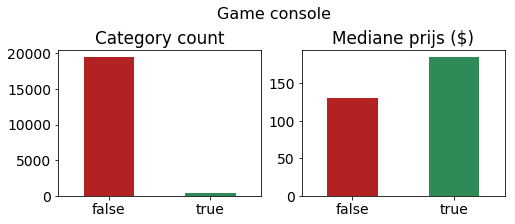

P-value is 1.96e-09
There are 19483 without Game console, with a median price of 130.0
There are 384 with Game console, with a median price of 185.0
Effect is significant!


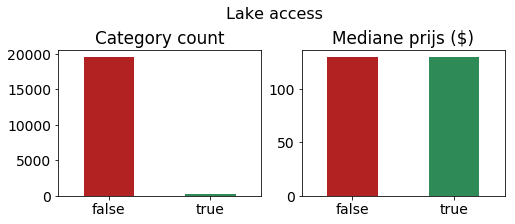

P-value is 2.26e-02
There are 19567 without Lake access, with a median price of 130.0
There are 300 with Lake access, with a median price of 130.0


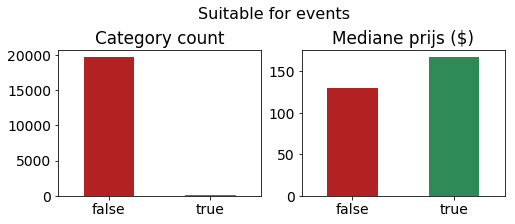

P-value is 3.21e-45
There are 19685 without Suitable for events, with a median price of 130.0
There are 182 with Suitable for events, with a median price of 167.5
Effect is significant!


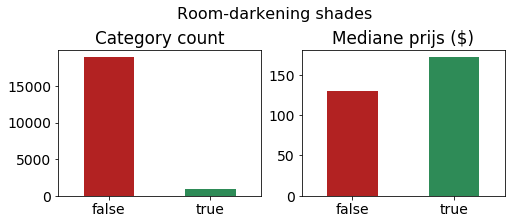

P-value is 5.13e-11
There are 18960 without Room-darkening shades, with a median price of 130.0
There are 907 with Room-darkening shades, with a median price of 172.0
Effect is significant!


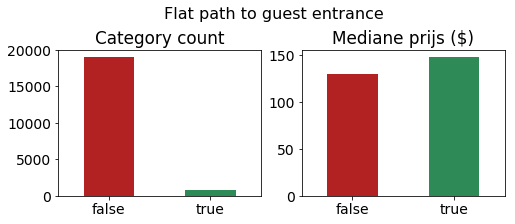

P-value is 7.39e-01
There are 19039 without Flat path to guest entrance, with a median price of 130.0
There are 828 with Flat path to guest entrance, with a median price of 148.0


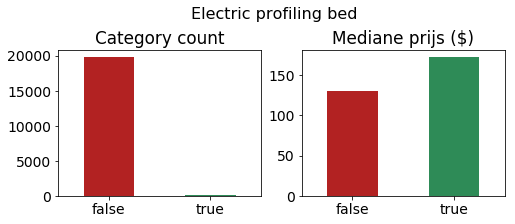

P-value is 4.33e-01
There are 19805 without Electric profiling bed, with a median price of 130.0
There are 62 with Electric profiling bed, with a median price of 172.5


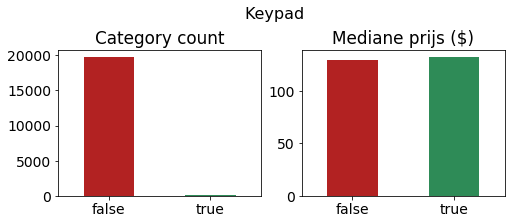

P-value is 9.48e-01
There are 19763 without Keypad, with a median price of 130.0
There are 104 with Keypad, with a median price of 132.5


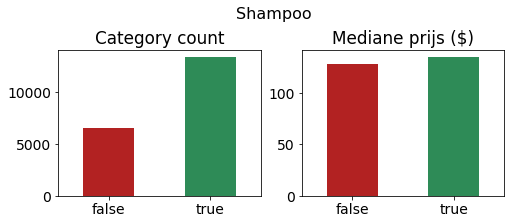

P-value is 4.94e-01
There are 6489 without Shampoo, with a median price of 128.0
There are 13378 with Shampoo, with a median price of 135.0


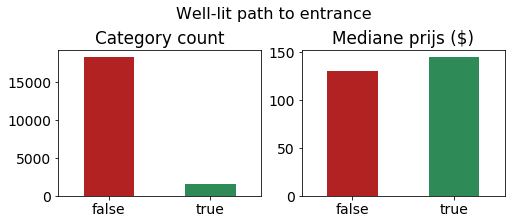

P-value is 9.43e-01
There are 18332 without Well-lit path to entrance, with a median price of 130.0
There are 1535 with Well-lit path to entrance, with a median price of 145.0


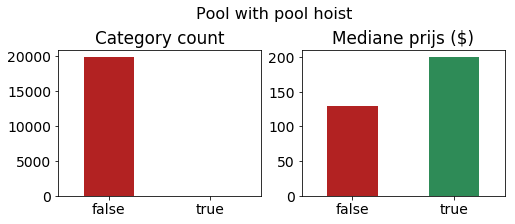

P-value is    nan
There are 19866 without Pool with pool hoist, with a median price of 130.0
There are 1 with Pool with pool hoist, with a median price of 200.0


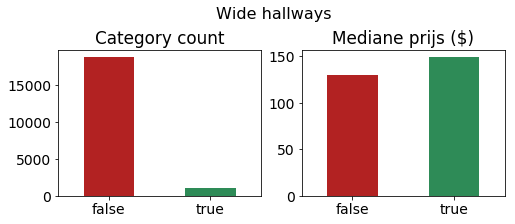

P-value is 1.83e-01
There are 18845 without Wide hallways, with a median price of 130.0
There are 1022 with Wide hallways, with a median price of 149.0


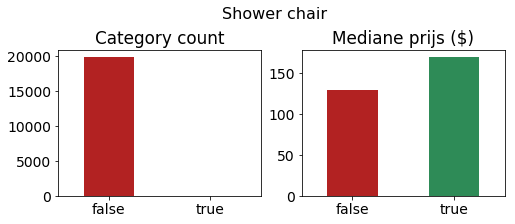

P-value is 3.84e-02
There are 19843 without Shower chair, with a median price of 130.0
There are 24 with Shower chair, with a median price of 170.0


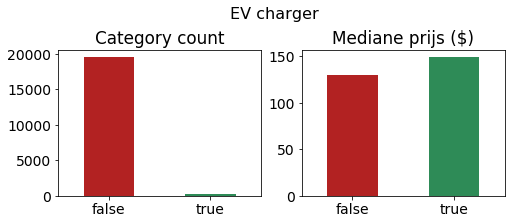

P-value is 3.35e-01
There are 19573 without EV charger, with a median price of 130.0
There are 294 with EV charger, with a median price of 149.0


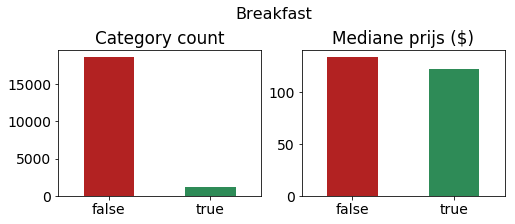

P-value is 1.67e-01
There are 18620 without Breakfast, with a median price of 133.5
There are 1247 with Breakfast, with a median price of 122.0


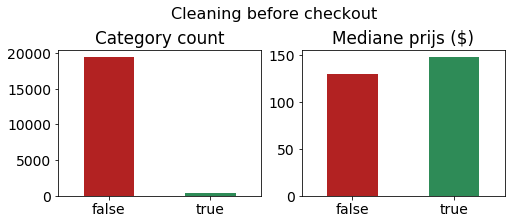

P-value is 2.48e-01
There are 19462 without Cleaning before checkout, with a median price of 130.0
There are 405 with Cleaning before checkout, with a median price of 148.0


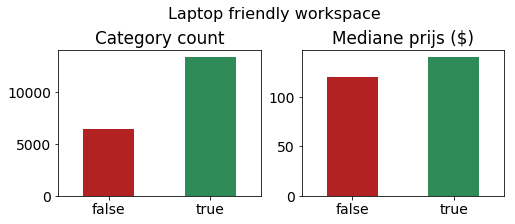

P-value is 2.93e-06
There are 6471 without Laptop friendly workspace, with a median price of 120.0
There are 13396 with Laptop friendly workspace, with a median price of 140.0
Effect is significant!


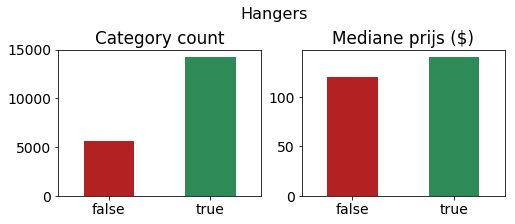

P-value is 2.37e-07
There are 5629 without Hangers, with a median price of 120.0
There are 14238 with Hangers, with a median price of 140.0
Effect is significant!


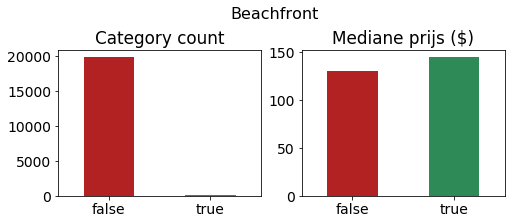

P-value is 9.69e-01
There are 19822 without Beachfront, with a median price of 130.0
There are 45 with Beachfront, with a median price of 145.0


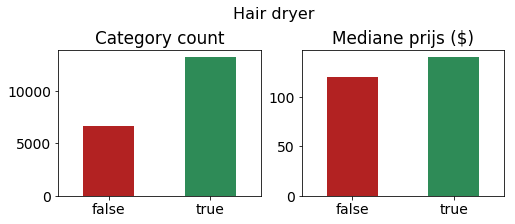

P-value is 8.35e-12
There are 6658 without Hair dryer, with a median price of 120.0
There are 13209 with Hair dryer, with a median price of 140.0
Effect is significant!


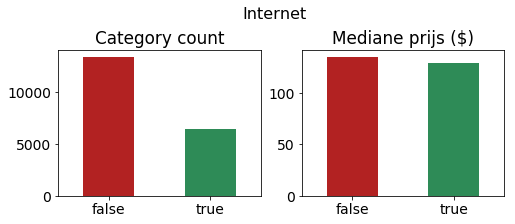

P-value is 4.41e-02
There are 13400 without Internet, with a median price of 135.0
There are 6467 with Internet, with a median price of 129.0


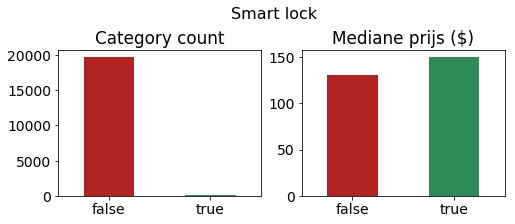

P-value is 7.30e-02
There are 19752 without Smart lock, with a median price of 130.0
There are 115 with Smart lock, with a median price of 150.0


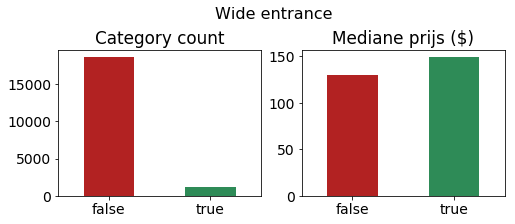

P-value is 3.94e-02
There are 18640 without Wide entrance, with a median price of 130.0
There are 1227 with Wide entrance, with a median price of 149.0


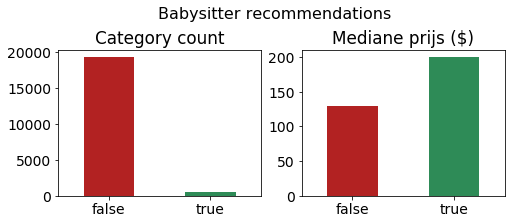

P-value is 2.10e-15
There are 19290 without Babysitter recommendations, with a median price of 130.0
There are 577 with Babysitter recommendations, with a median price of 200.0
Effect is significant!


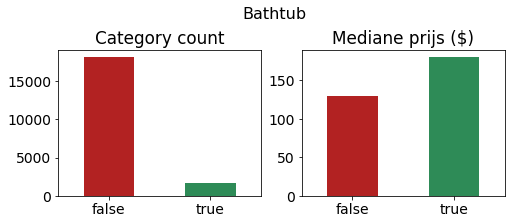

P-value is 7.38e-37
There are 18155 without Bathtub, with a median price of 129.0
There are 1712 with Bathtub, with a median price of 180.0
Effect is significant!


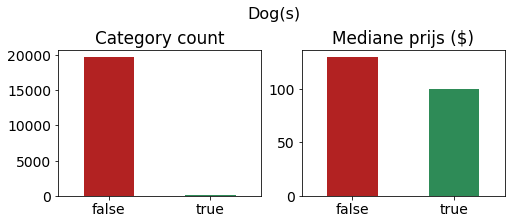

P-value is 4.66e-02
There are 19731 without Dog(s), with a median price of 130.0
There are 136 with Dog(s), with a median price of 100.0


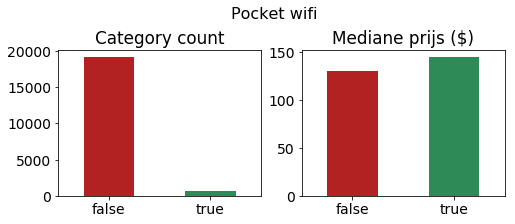

P-value is 4.66e-01
There are 19197 without Pocket wifi, with a median price of 130.0
There are 670 with Pocket wifi, with a median price of 145.0


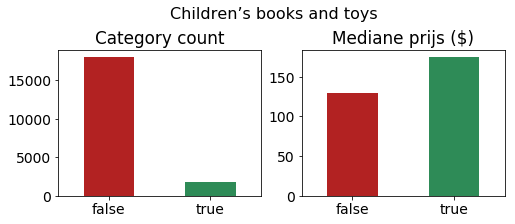

P-value is 1.97e-18
There are 18058 without Children’s books and toys, with a median price of 129.0
There are 1809 with Children’s books and toys, with a median price of 175.0
Effect is significant!


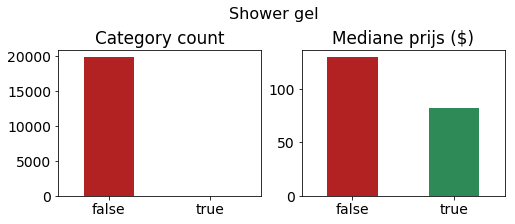

P-value is 3.07e-01
There are 19857 without Shower gel, with a median price of 130.0
There are 10 with Shower gel, with a median price of 82.5


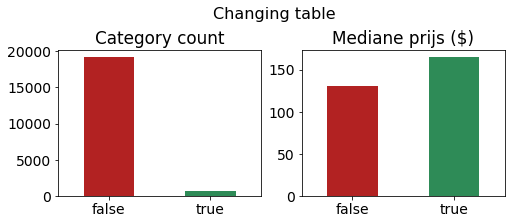

P-value is 7.09e-08
There are 19219 without Changing table, with a median price of 130.0
There are 648 with Changing table, with a median price of 165.0
Effect is significant!


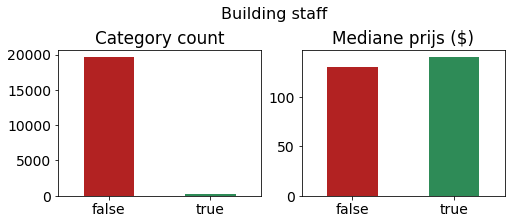

P-value is 2.90e-01
There are 19659 without Building staff, with a median price of 130.0
There are 208 with Building staff, with a median price of 140.0


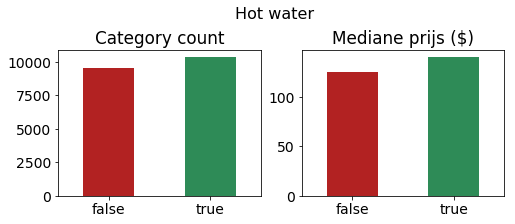

P-value is 3.58e-08
There are 9514 without Hot water, with a median price of 125.0
There are 10353 with Hot water, with a median price of 140.0
Effect is significant!


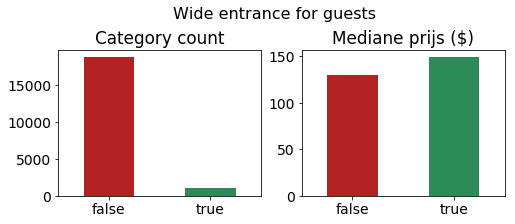

P-value is 6.68e-02
There are 18837 without Wide entrance for guests, with a median price of 130.0
There are 1030 with Wide entrance for guests, with a median price of 149.0


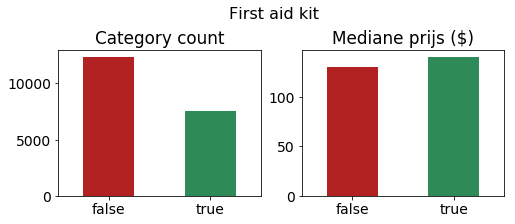

P-value is 3.33e-11
There are 12355 without First aid kit, with a median price of 130.0
There are 7512 with First aid kit, with a median price of 140.0
Effect is significant!


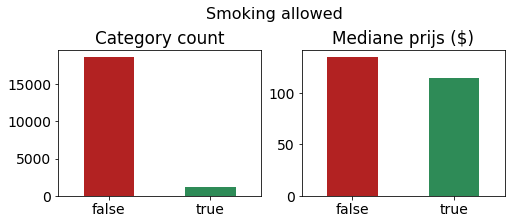

P-value is 2.00e-01
There are 18624 without Smoking allowed, with a median price of 135.0
There are 1243 with Smoking allowed, with a median price of 115.0


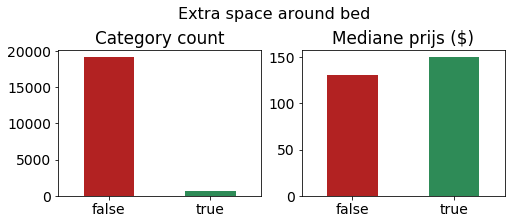

P-value is 8.85e-04
There are 19162 without Extra space around bed, with a median price of 130.0
There are 705 with Extra space around bed, with a median price of 150.0


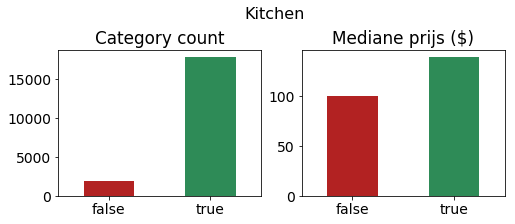

P-value is 1.86e-07
There are 1970 without Kitchen, with a median price of 100.0
There are 17897 with Kitchen, with a median price of 139.0
Effect is significant!


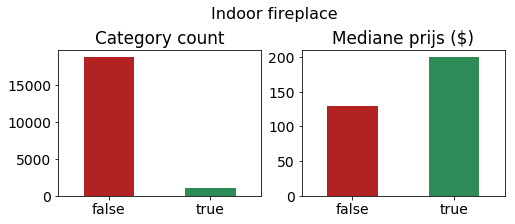

P-value is 1.76e-55
There are 18768 without Indoor fireplace, with a median price of 130.0
There are 1099 with Indoor fireplace, with a median price of 200.0
Effect is significant!


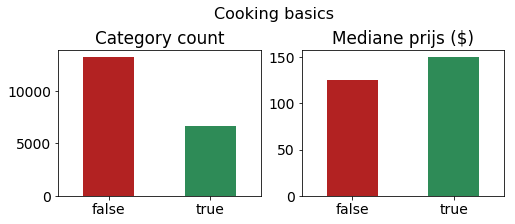

P-value is 5.36e-13
There are 13228 without Cooking basics, with a median price of 125.0
There are 6639 with Cooking basics, with a median price of 150.0
Effect is significant!


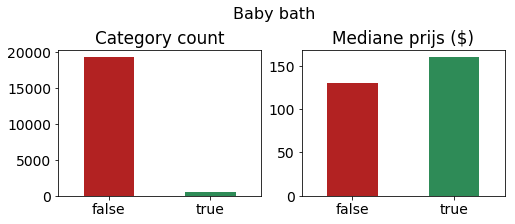

P-value is 9.04e-05
There are 19311 without Baby bath, with a median price of 130.0
There are 556 with Baby bath, with a median price of 160.0
Effect is significant!


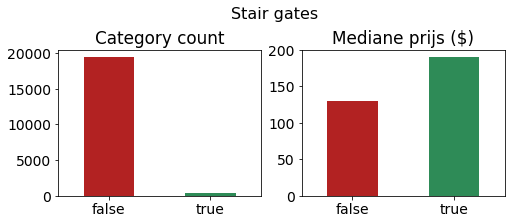

P-value is 6.23e-08
There are 19463 without Stair gates, with a median price of 130.0
There are 404 with Stair gates, with a median price of 190.0
Effect is significant!


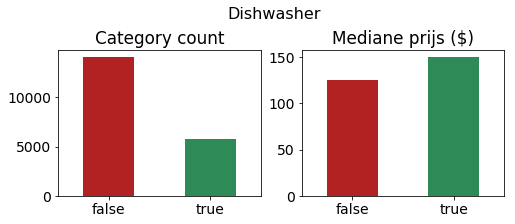

P-value is 1.17e-23
There are 14087 without Dishwasher, with a median price of 125.0
There are 5780 with Dishwasher, with a median price of 150.0
Effect is significant!


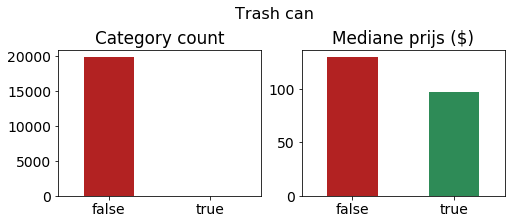

P-value is 4.77e-01
There are 19855 without Trash can, with a median price of 130.0
There are 12 with Trash can, with a median price of 97.5


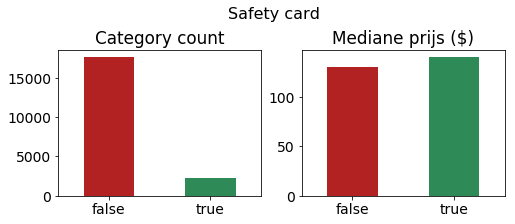

P-value is 1.04e-10
There are 17651 without Safety card, with a median price of 130.0
There are 2216 with Safety card, with a median price of 140.0
Effect is significant!


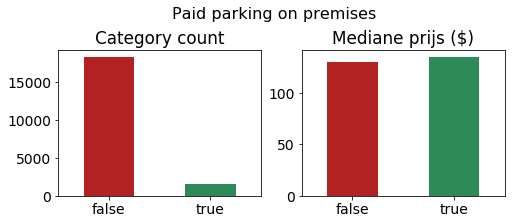

P-value is 5.18e-01
There are 18334 without Paid parking on premises, with a median price of 130.0
There are 1533 with Paid parking on premises, with a median price of 135.0


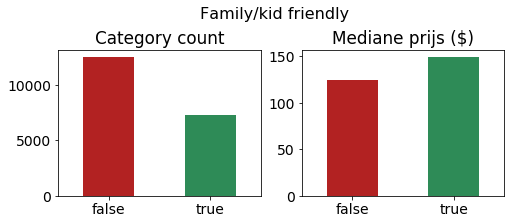

P-value is 4.96e-15
There are 12531 without Family/kid friendly, with a median price of 125.0
There are 7336 with Family/kid friendly, with a median price of 149.5
Effect is significant!


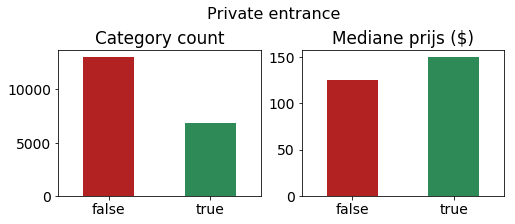

P-value is 1.17e-31
There are 13051 without Private entrance, with a median price of 125.0
There are 6816 with Private entrance, with a median price of 150.0
Effect is significant!


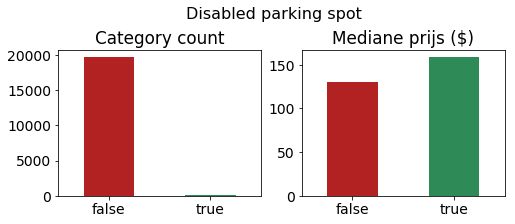

P-value is 2.76e-01
There are 19715 without Disabled parking spot, with a median price of 130.0
There are 152 with Disabled parking spot, with a median price of 159.0


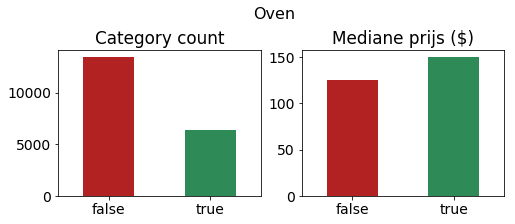

P-value is 6.37e-17
There are 13455 without Oven, with a median price of 125.0
There are 6412 with Oven, with a median price of 150.0
Effect is significant!


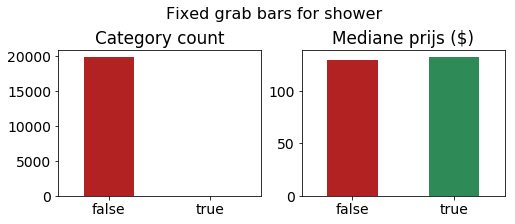

P-value is 6.76e-01
There are 19831 without Fixed grab bars for shower, with a median price of 130.0
There are 36 with Fixed grab bars for shower, with a median price of 132.5


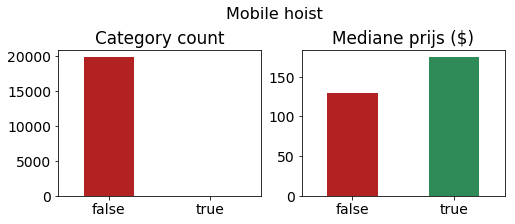

P-value is 9.33e-01
There are 19865 without Mobile hoist, with a median price of 130.0
There are 2 with Mobile hoist, with a median price of 175.0


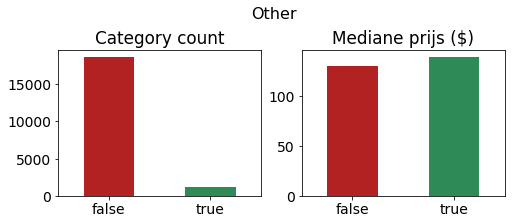

P-value is 3.13e-05
There are 18666 without Other, with a median price of 130.0
There are 1201 with Other, with a median price of 139.0
Effect is significant!


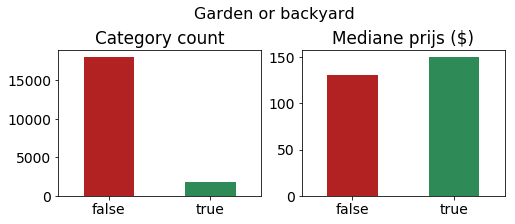

P-value is 2.31e-03
There are 18021 without Garden or backyard, with a median price of 130.0
There are 1846 with Garden or backyard, with a median price of 150.0


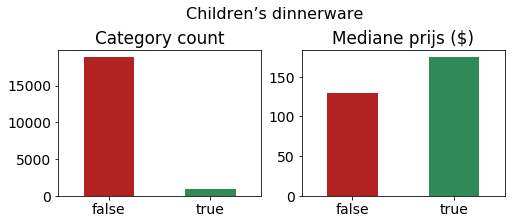

P-value is 9.97e-16
There are 18890 without Children’s dinnerware, with a median price of 130.0
There are 977 with Children’s dinnerware, with a median price of 175.0
Effect is significant!


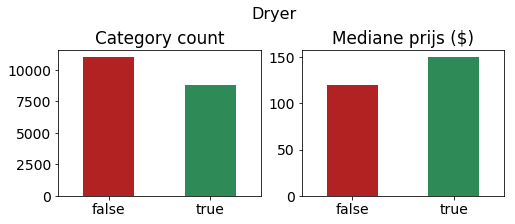

P-value is 1.21e-37
There are 11039 without Dryer, with a median price of 120.0
There are 8828 with Dryer, with a median price of 150.0
Effect is significant!


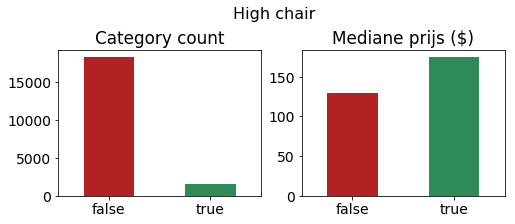

P-value is 6.68e-19
There are 18335 without High chair, with a median price of 130.0
There are 1532 with High chair, with a median price of 175.0
Effect is significant!


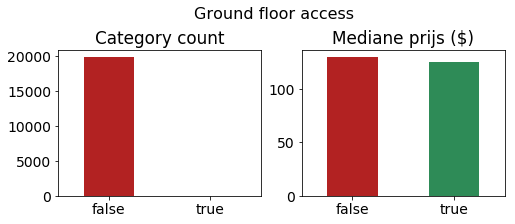

P-value is 8.74e-01
There are 19860 without Ground floor access, with a median price of 130.0
There are 7 with Ground floor access, with a median price of 125.0


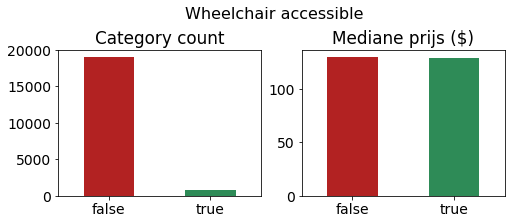

P-value is 4.98e-02
There are 19025 without Wheelchair accessible, with a median price of 130.0
There are 842 with Wheelchair accessible, with a median price of 129.0


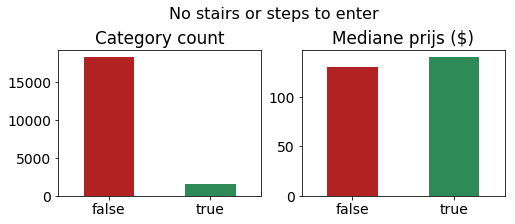

P-value is 2.64e-01
There are 18259 without No stairs or steps to enter, with a median price of 130.0
There are 1608 with No stairs or steps to enter, with a median price of 140.0


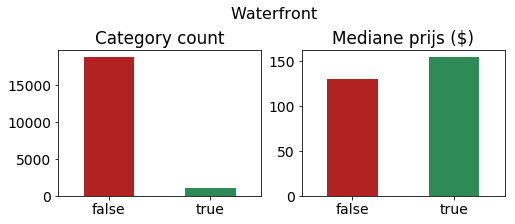

P-value is 4.00e-16
There are 18770 without Waterfront, with a median price of 130.0
There are 1097 with Waterfront, with a median price of 155.0
Effect is significant!


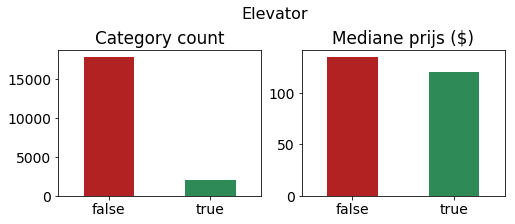

P-value is 5.91e-01
There are 17858 without Elevator, with a median price of 135.0
There are 2009 with Elevator, with a median price of 120.0


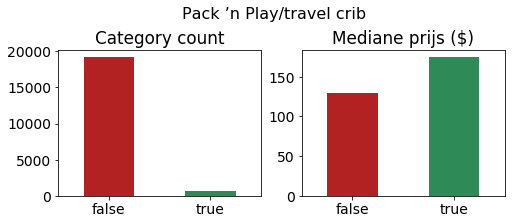

P-value is 2.48e-08
There are 19226 without Pack ’n Play/travel crib, with a median price of 130.0
There are 641 with Pack ’n Play/travel crib, with a median price of 175.0
Effect is significant!


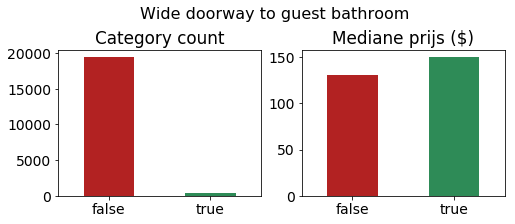

P-value is 3.05e-02
There are 19454 without Wide doorway to guest bathroom, with a median price of 130.0
There are 413 with Wide doorway to guest bathroom, with a median price of 150.0


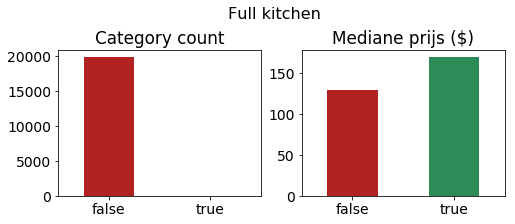

P-value is    nan
There are 19866 without Full kitchen, with a median price of 130.0
There are 1 with Full kitchen, with a median price of 170.0


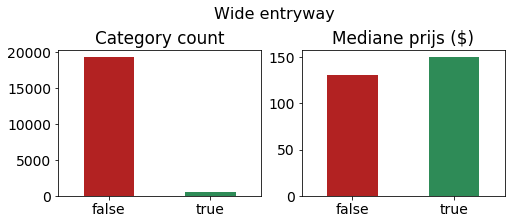

P-value is 2.80e-03
There are 19322 without Wide entryway, with a median price of 130.0
There are 545 with Wide entryway, with a median price of 150.0


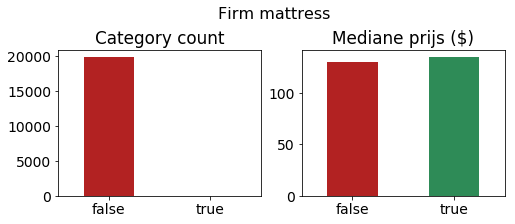

P-value is 2.86e-01
There are 19843 without Firm mattress, with a median price of 130.0
There are 24 with Firm mattress, with a median price of 135.0


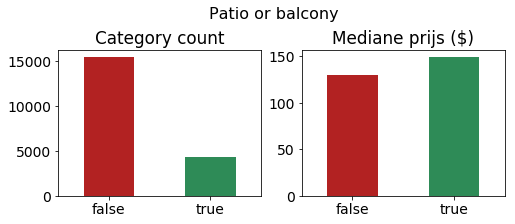

P-value is 1.62e-03
There are 15494 without Patio or balcony, with a median price of 130.0
There are 4373 with Patio or balcony, with a median price of 149.0


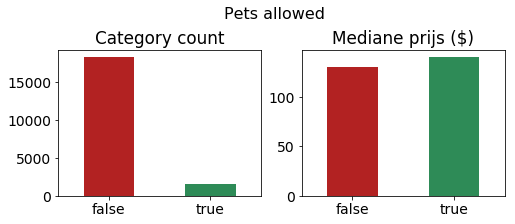

P-value is 4.15e-04
There are 18347 without Pets allowed, with a median price of 130.0
There are 1520 with Pets allowed, with a median price of 140.0
Effect is significant!


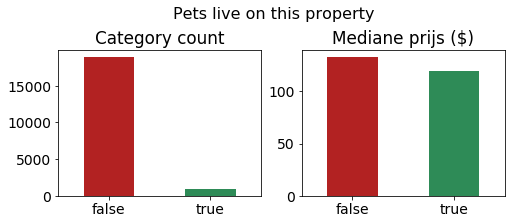

P-value is 3.81e-02
There are 18901 without Pets live on this property, with a median price of 133.0
There are 966 with Pets live on this property, with a median price of 120.0


In [46]:
# Plot counts, median price and calculate t-test P-value for every amenity
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_price_plot(col) for col in df.iloc[:,44:-1].columns]

In [47]:
import math
cleanpvalues = {}
allpvalues = dict(zip(df.iloc[:,44:-1].columns.values, result))
#type(allpvalues)
for key in allpvalues:
    #print(key)
    #print(allpvalues[key])
    if math.isnan(allpvalues[key]):
        print("nan found for: ", key)
    else:
        #print("nan found")
        cleanpvalues[key] = allpvalues[key]

nan found for:  Roll-in shower with chair
nan found for:  Bread maker
nan found for:  Pool with pool hoist
nan found for:  Full kitchen


P-values van het effect van elke amenity op prijs wordt vervangen door de -log(P) waarde voor leesbaarheid, en gesorteerd:

In [48]:
# -log Pvalues and order
cleanpvalues.update({k: -1*np.log(v) for k, v in cleanpvalues.items()})
ordereddict = OrderedDict(sorted(cleanpvalues.items(), key=lambda t: t[1]))

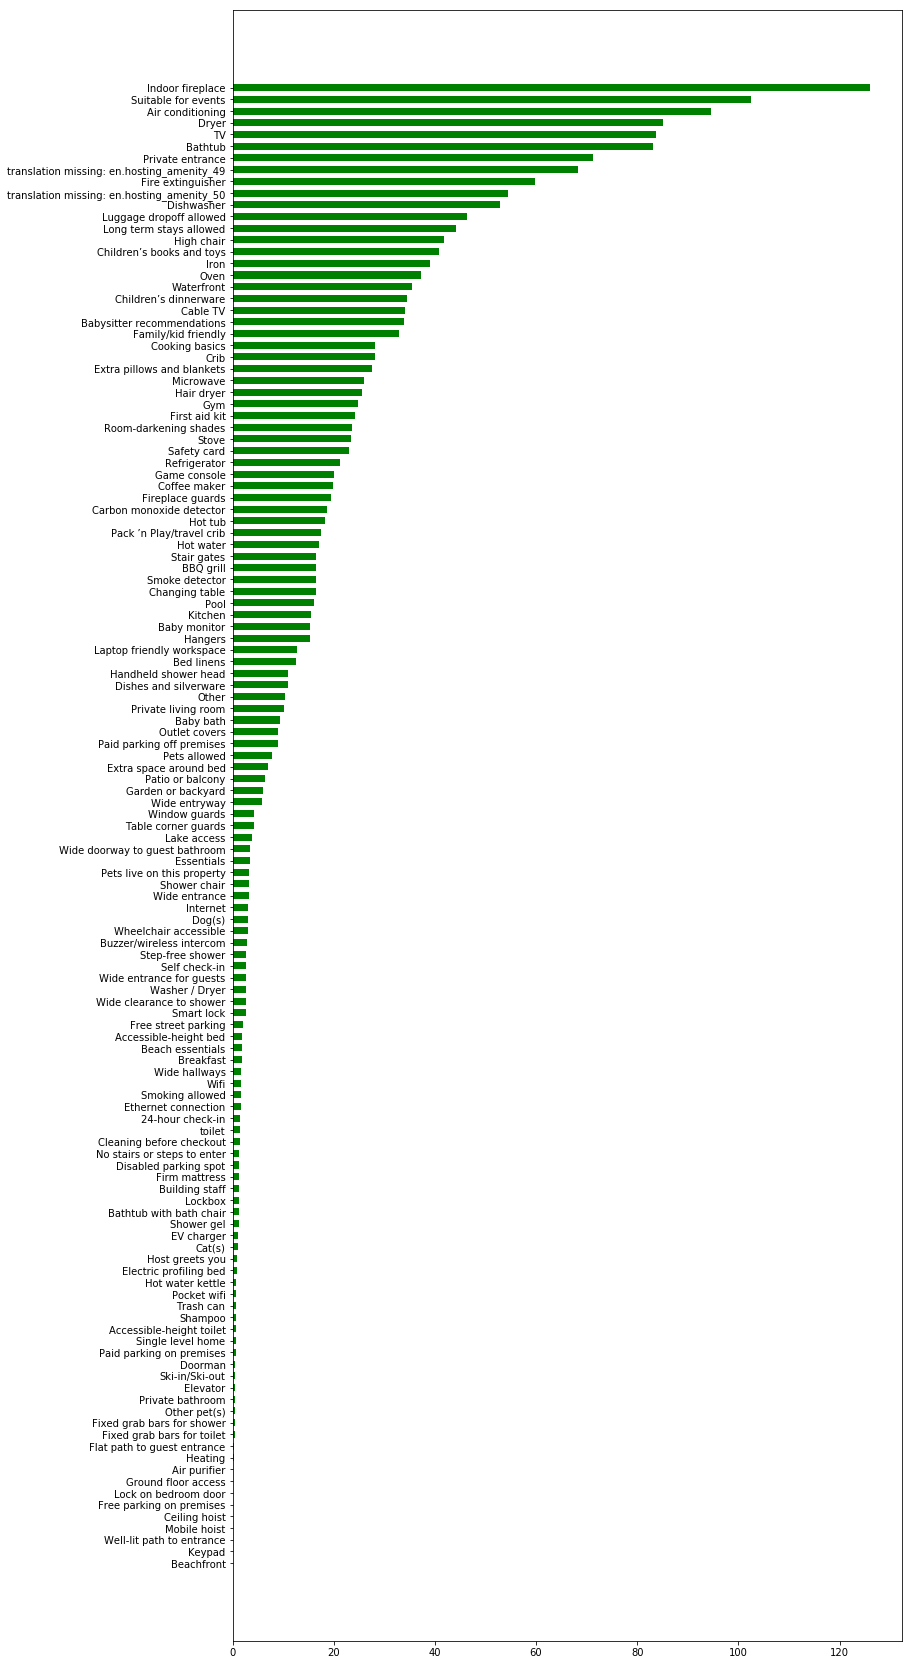

In [49]:
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 12, 30
plt.barh(list(ordereddict.keys()), list(ordereddict.values()),color='g', height=0.6)
plt.show()

In [50]:
# plt.rcParams['font.size'] = 10
# plt.rcParams['figure.figsize'] = 120, 300
# # for col in df.iloc[:,41:-1].columns:
#     pvalue = binary_count_and_price_plot(col, figsize=(6,2))

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 06 December 2019.


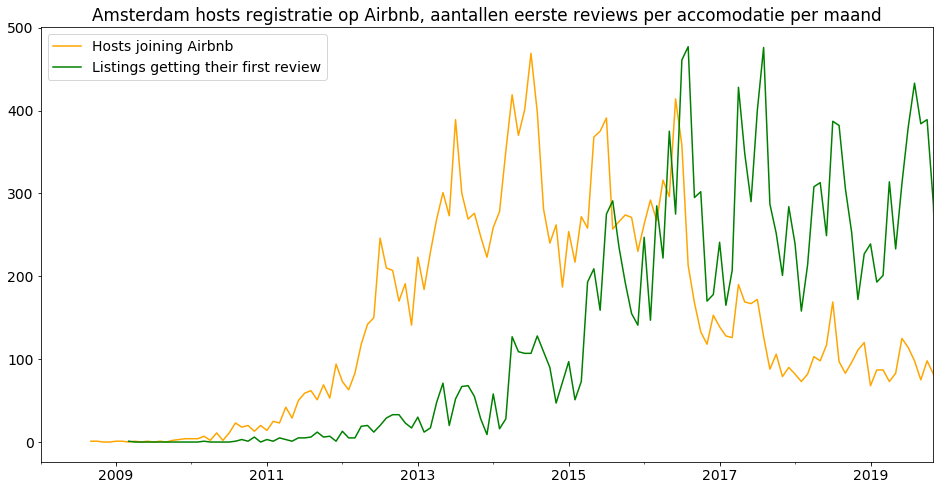

In [51]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 16, 8

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")


df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Amsterdam hosts registratie op Airbnb, aantallen eerste reviews per accomodatie per maand')
plt.legend()
plt.xlim('2008-01-01', '2019-11-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

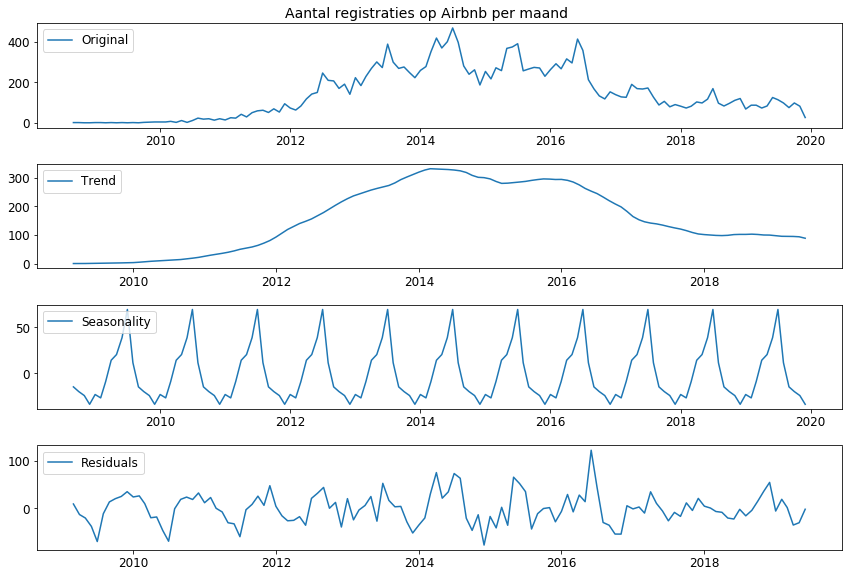

In [52]:

# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 50, 70
decompose_time_series(ts_host_since, title='Aantal registraties op Airbnb per maand')